# Spotify Music Analysis
## Alankrit Joshi & Harshdeep Singh
### CS6140 - Machine Learning

## Imports

In [360]:
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from pandas.plotting import parallel_coordinates

import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score, roc_curve, average_precision_score,precision_recall_curve,accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import scipy.interpolate as interpolate

from mlxtend.plotting import plot_decision_regions

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

from pprint import pprint

import glob, os, re
from functools import partial

from IPython.display import display

In [145]:
tls.set_credentials_file(username='alankritjoshi', api_key='Ci8tjiLY8s59mqpw7PXe')
random_state = 346

## Styling & Settings

In [146]:
%matplotlib inline
sns.set(style='ticks', palette='Spectral', font_scale=1.5)

material_palette = ["#4CAF50", "#2196F3", "#9E9E9E", "#FF9800", "#607D8B", "#9C27B0"]
sns.set_palette(material_palette)
rcParams['figure.figsize'] = 16, 8

plt.xkcd();
random_state = 42
np.random.seed(random_state)
tf.set_random_seed(random_state)

## File handling helpers

In [147]:
def data_loader(title):
    '''
    load data from txt file for given title

    @param title: string for denoting type of data
    @return X: numpy array of features
    '''
    return np.loadtxt('{}.txt'.format(title))

In [148]:
def data_saver(title, data):
    '''
    save given data to txt file for given title

    @param data: data to save
    @param title: string for denoting type of data
    '''
    np.savetxt('{}.txt'.format(title), data, delimiter=',')

## Spoti**f**y credentials and Spoti**p**y initialization # TODO: change to environment variables for security

In [149]:
def get_spotipy_token(client_id=None, client_secret=None):
    if client_id and client_secret:
        token = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
        cache_token = token.get_access_token()
        return spotipy.Spotify(cache_token)
    # TODO: try to check environment variables
    return None

In [150]:
CLIENT_ID = '591f8cac8f3447319e0c44e45cceb650'
CLIENT_SECRET = 'a6dab88a32234c7dbc322573ca7c122a'
spot = get_spotipy_token(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

## Data extraction helpers

In [151]:
def get_playlist_tracks(username, playlist_id):
    results = spot.user_playlist_tracks(username, playlist_id)
    tracks = results['items']
    while results['next']:
        results = spot.next(results)
        tracks.extend(results['items'])
    tracks = [each['track'] for each in tracks]
    return tracks

In [152]:
def clean_tracks(tracks, fields=['id', 'name', 'album', 'artists', 'available_markets', 'external_urls', 'popularity', 'preview_url']):
    for index, track in enumerate(tracks):
        track = { field: track[field] for field in fields }
        if 'album' in fields:
            track['album'] = track['album']['name']
        if 'artists' in fields:
            track['artists'] = [artist['name'] for artist in track['artists']]
        if 'external_urls' in fields and 'external_urls' in track and 'spotify' in track['external_urls']:
            track['external_urls'] = track['external_urls']['spotify']
        tracks[index] = track
    return tracks

In [153]:
def get_track_ids(tracks):
    ids = list()
    for track in tracks:
        if (track['id'] is not None):
            ids.append(track['id'])
    return ids

In [154]:
def get_track_features(ids):
    features = list()
    for i in range(0,len(ids),50):
        audio_features = spot.audio_features(ids[i:i+50])
        for track in audio_features:
            features.append(track)
    return features

In [155]:
def clean_audio_features(features, fields=['id', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence', 'duration_ms']):
    for index, feature in enumerate(features):
        feature = { field: feature[field] for field in fields }
        features[index] = feature
    return features

## Data extraction explained (go to [implementation](#data_helper)) <a id='data_helper_explanation'></a>

### Fetch and clean tracks for a random playlist

In [156]:
raw_tracks = get_playlist_tracks("11124059958", "58mpINjST18mK6qvvPYRzO")

In [157]:
cleaned_tracks = clean_tracks(raw_tracks, fields=['id', 'name', 'popularity'])
tracks_df = pd.DataFrame(cleaned_tracks)
pprint('Track Features Shape: {0}'.format(tracks_df.shape))
tracks_df.head(5)

'Track Features Shape: (2504, 3)'


id 
 name 
 popularity 
 
 
 
 
 0 
 6KplFHsf2CHGvl1YVzq26S 
 Candyland 
 51 
 
 
 1 
 4bkDdk64NpiQB4RCDZi6bp 
 Safari Fruits 
 49 
 
 
 2 
 3Wo3vfbVLzvuvxMNL2R7rQ 
 Hollah! 
 48 
 
 
 3 
 3hR2IpnyrI6NvUvLB0RVni 
 Entropy 
 55 
 
 
 4 
 6ULbkJ16YabZNdJMHsIVmE 
 Nekozilla 
 62

### Get track IDs, fetch audio features using the IDs and clean the features

In [158]:
track_ids = get_track_ids(cleaned_tracks)

In [159]:
audio_features = get_track_features(track_ids)

In [160]:
cleaned_audio_features = clean_audio_features(audio_features)
audio_features_df = pd.DataFrame(cleaned_audio_features)
pprint('Audio Features Shape: {0}'.format(audio_features_df.shape))
audio_features_df.head(5)

'Audio Features Shape: (1966, 13)'


acousticness 
 danceability 
 duration_ms 
 energy 
 id 
 instrumentalness 
 key 
 liveness 
 loudness 
 mode 
 speechiness 
 tempo 
 valence 
 
 
 
 
 0 
 0.051200 
 0.688 
 200640 
 0.868 
 6KplFHsf2CHGvl1YVzq26S 
 0.00121 
 4 
 0.4690 
 -4.183 
 1 
 0.0396 
 127.990 
 0.322 
 
 
 1 
 0.012100 
 0.696 
 225634 
 0.903 
 4bkDdk64NpiQB4RCDZi6bp 
 0.74700 
 0 
 0.3510 
 -5.737 
 1 
 0.0672 
 142.036 
 0.624 
 
 
 2 
 0.003590 
 0.851 
 160993 
 0.400 
 3Wo3vfbVLzvuvxMNL2R7rQ 
 0.00696 
 0 
 0.1130 
 -10.026 
 0 
 0.0731 
 140.073 
 0.320 
 
 
 3 
 0.001210 
 0.722 
 204894 
 0.885 
 3hR2IpnyrI6NvUvLB0RVni 
 0.38600 
 9 
 0.3580 
 -4.858 
 1 
 0.0387 
 129.968 
 0.172 
 
 
 4 
 0.000387 
 0.745 
 168760 
 0.905 
 6ULbkJ16YabZNdJMHsIVmE 
 0.14800 
 6 
 0.0699 
 -5.182 
 0 
 0.0473 
 128.031 
 0.378

### Join tracks and features to get combined dataset for a playlist

In [161]:
data = pd.merge(tracks_df, audio_features_df, how='inner', on='id')
pprint('Data Shape: {0}'.format(data.shape))
data.head(5)

'Data Shape: (2086, 15)'


id 
 name 
 popularity 
 acousticness 
 danceability 
 duration_ms 
 energy 
 instrumentalness 
 key 
 liveness 
 loudness 
 mode 
 speechiness 
 tempo 
 valence 
 
 
 
 
 0 
 6KplFHsf2CHGvl1YVzq26S 
 Candyland 
 51 
 0.051200 
 0.688 
 200640 
 0.868 
 0.00121 
 4 
 0.4690 
 -4.183 
 1 
 0.0396 
 127.990 
 0.322 
 
 
 1 
 4bkDdk64NpiQB4RCDZi6bp 
 Safari Fruits 
 49 
 0.012100 
 0.696 
 225634 
 0.903 
 0.74700 
 0 
 0.3510 
 -5.737 
 1 
 0.0672 
 142.036 
 0.624 
 
 
 2 
 3Wo3vfbVLzvuvxMNL2R7rQ 
 Hollah! 
 48 
 0.003590 
 0.851 
 160993 
 0.400 
 0.00696 
 0 
 0.1130 
 -10.026 
 0 
 0.0731 
 140.073 
 0.320 
 
 
 3 
 3hR2IpnyrI6NvUvLB0RVni 
 Entropy 
 55 
 0.001210 
 0.722 
 204894 
 0.885 
 0.38600 
 9 
 0.3580 
 -4.858 
 1 
 0.0387 
 129.968 
 0.172 
 
 
 4 
 6ULbkJ16YabZNdJMHsIVmE 
 Nekozilla 
 62 
 0.000387 
 0.745 
 168760 
 0.905 
 0.14800 
 6 
 0.0699 
 -5.182 
 0 
 0.0473 
 128.031 
 0.378

## Playlist data helper <a id='data_helper'></a> (go to [explanation](#data_helper_explanation))

In [162]:
def get_playlist_data(username, playlist_id, track_fields=['id', 'name', 'popularity']):
    raw_tracks = get_playlist_tracks(username, playlist_id)
    cleaned_tracks = clean_tracks(raw_tracks, fields=track_fields)
    tracks_df = pd.DataFrame(cleaned_tracks)
    track_ids = get_track_ids(cleaned_tracks)
    audio_features = get_track_features(track_ids)
    cleaned_audio_features = clean_audio_features(audio_features)
    audio_features_df = pd.DataFrame(cleaned_audio_features)
    playlist_data = pd.merge(tracks_df, audio_features_df, how='inner', on='id')
    return playlist_data

### Testing playlist data helper

In [163]:
playlist_data = get_playlist_data("11124059958", "58mpINjST18mK6qvvPYRzO")
playlist_data.head(5)

id 
 name 
 popularity 
 acousticness 
 danceability 
 duration_ms 
 energy 
 instrumentalness 
 key 
 liveness 
 loudness 
 mode 
 speechiness 
 tempo 
 valence 
 
 
 
 
 0 
 6KplFHsf2CHGvl1YVzq26S 
 Candyland 
 51 
 0.051200 
 0.688 
 200640 
 0.868 
 0.00121 
 4 
 0.4690 
 -4.183 
 1 
 0.0396 
 127.990 
 0.322 
 
 
 1 
 4bkDdk64NpiQB4RCDZi6bp 
 Safari Fruits 
 49 
 0.012100 
 0.696 
 225634 
 0.903 
 0.74700 
 0 
 0.3510 
 -5.737 
 1 
 0.0672 
 142.036 
 0.624 
 
 
 2 
 3Wo3vfbVLzvuvxMNL2R7rQ 
 Hollah! 
 48 
 0.003590 
 0.851 
 160993 
 0.400 
 0.00696 
 0 
 0.1130 
 -10.026 
 0 
 0.0731 
 140.073 
 0.320 
 
 
 3 
 3hR2IpnyrI6NvUvLB0RVni 
 Entropy 
 55 
 0.001210 
 0.722 
 204894 
 0.885 
 0.38600 
 9 
 0.3580 
 -4.858 
 1 
 0.0387 
 129.968 
 0.172 
 
 
 4 
 6ULbkJ16YabZNdJMHsIVmE 
 Nekozilla 
 62 
 0.000387 
 0.745 
 168760 
 0.905 
 0.14800 
 6 
 0.0699 
 -5.182 
 0 
 0.0473 
 128.031 
 0.378

## All playlists data helper

In [164]:
def get_data(playlists):
    for playlist in playlists:
        yield (get_playlist_data(playlist[2], playlist[0]), playlist[1], playlist[3])

### Testing all playlists data helper

In [165]:
test_playlists = list()
test_playlists.append(("37i9dQZF1DX9dp45EzSeyl", "RapCaviar: Best of 2017", "spotify", "Rap"))
test_playlists.append(("37i9dQZF1DX4ykqMZqUn3L", "Top Tracks of 2017", "spotify", "Unknown"))

for playlist_data, playlist_name, _ in get_data(test_playlists):
    # process
    #  data[playlist_name] = playlist_data
    #  or
    #  playlist_data.to_csv(playlist_name)
    print('Processed {}: {}'.format(playlist_name, playlist_data.shape))

Processed RapCaviar: Best of 2017: (50, 15)


Processed Top Tracks of 2017: (50, 15)


## Find playlists of multiple genres

### Available Genre seeds in Spotify:

"acoustic", "afrobeat", "alt-rock", "alternative", "ambient", "anime", "black-metal", "bluegrass", "blues", "bossanova", "brazil", "breakbeat", "british", "cantopop", "chicago-house", "children", "chill", "classical", "club", "comedy", "country", "dance", "dancehall", "death-metal", "deep-house", "detroit-techno", "disco", "disney", "drum-and-bass", "dub", "dubstep", "edm", "electro", "electronic", "emo", "folk", "forro", "french", "funk", "garage", "german", "gospel", "goth", "grindcore", "groove", "grunge", "guitar", "happy", "hard-rock", "hardcore", "hardstyle", "heavy-metal", "hip-hop", "holidays", "honky-tonk", "house", "idm", "indian", "indie", "indie-pop", "industrial", "iranian", "j-dance", "j-idol", "j-pop", "j-rock", "jazz", "k-pop", "kids", "latin", "latino", "malay", "mandopop", "metal", "metal-misc", "metalcore", "minimal-techno", "movies", "mpb", "new-age", "new-release", "opera", "pagode", "party", "philippines-opm", "piano", "pop", "pop-film", "post-dubstep", "power-pop", "progressive-house", "psych-rock", "punk", "punk-rock", "r-n-b", "rainy-day", "reggae", "reggaeton", "road-trip", "rock", "rock-n-roll", "rockabilly", "romance", "sad", "salsa", "samba", "sertanejo", "show-tunes", "singer-songwriter", "ska", "sleep", "songwriter", "soul", "soundtracks", "spanish", "study", "summer", "swedish", "synth-pop", "tango", "techno", "trance", "trip-hop", "turkish", "work-out", "world-music"

In [166]:
list_playlists = pd.read_csv('links.csv',sep='\t')

In [167]:
list_playlists

id 
 name 
 username 
 genre 
 
 
 
 
 0 
 1ivryZNhNH9aR5AIreeuT2 
 dance playlist2017 
 piclub 
 dance 
 
 
 1 
 37i9dQZF1DWYEA2z2jQnzS 
 mint: Best of 2017 
 spotify 
 dance 
 
 
 2 
 42CFA1F8ueGRJ0lqNfNwaQ 
 Indian 2017 songs 
 f4fsua9akd1zri1ukrhcawvjf 
 indian 
 
 
 3 
 3TbygdukIQBff0OgaSKQvh 
 ROMANCE 2017 
 skyplayer38 
 romance 
 
 
 4 
 37i9dQZF1DXcN1fAVSf7CR 
 Top Classical of 2017 
 spotify 
 classical 
 
 
 5 
 2hXf2dumKw36as8U9h7lHo 
 Acoustic Pop Covers 2016 - 2018 
 1196507886 
 acoustic 
 
 
 6 
 1ZQ68B1HiaK1MVNdyAlc83 
 Acoustic Hits 2017 / 2018 
 mrcoyeii 
 acoustic 
 
 
 7 
 4U9F19FaajvU93ZNQswgDv 
 Techno 2017 
 pinguinette11 
 techno 
 
 
 8 
 6txd2VY1EFdQa0wlhdUOy2 
 Metal 2017-2018 
 t3ri0k 
 metal 
 
 
 9 
 37i9dQZF1DXcOFePJj4Rgb 
 Pop 2017 
 spotify 
 pop 
 
 
 10 
 3cqW3anXmlCrmKAksZ4xfE 
 Pop Playlist 2017 - 2018 
 1126992078 
 pop 
 
 
 11 
 02bE2dnA62pgAodpvrhvCP 
 Jazz Dance Class 2017 
 eecusack 
 jazz 
 
 
 12 
 37i9dQZF1DX1Jg9KZ76Rr9 
 Rock This: Best of 2017 
 spotify 
 rock 
 
 
 13 
 37i9dQZF1DX1lVhptIYRda 
 Hot Country 
 spotify 
 country 
 
 
 14 
 0rBB7zYgvUe4OYKGhufHW5 
 Clean Hip Hop Rap and R&B 
 bbswag03op 
 rap 
 
 
 15 
 5YjM08TSB5ZHhcYfPV8DfM 
 Rap Workout Playlist 
 alexm1229 
 rap

## Write all the playlists' music into respective files

In [168]:
def write_playlists_tracks_to_files(playlists_df, location='data/', verbose=False):
    playlists_tuples = [tuple(x) for x in playlists_df.values]
    for playlist_data, playlist_name, playlist_genre in get_data(playlists_tuples):
        playlist_data['genre'] = playlist_genre
        playlist_name = re.sub('[^a-zA-Z0-9 ]', '', playlist_name).lower()
        playlist_name = '-'.join(playlist_name.split())
        playlist_data.to_csv('{}{}-{}.csv'.format(location, playlist_genre.upper(), playlist_name), sep='\t')
        if verbose:
            print('Processed genre:{0:10} playlist with {1:4} tracks by saving in data/{2}-{3}.csv'.format(playlist_genre, playlist_data.shape[0], playlist_genre.upper(), playlist_name))

In [169]:
write_playlists_tracks_to_files(list_playlists, verbose=True)

Processed genre:dance      playlist with  349 tracks by saving in data/DANCE-dance-playlist2017.csv


Processed genre:dance      playlist with   99 tracks by saving in data/DANCE-mint-best-of-2017.csv


Processed genre:indian     playlist with  111 tracks by saving in data/INDIAN-indian-2017-songs.csv


Processed genre:romance    playlist with  127 tracks by saving in data/ROMANCE-romance-2017.csv


Processed genre:classical  playlist with  100 tracks by saving in data/CLASSICAL-top-classical-of-2017.csv


Processed genre:acoustic   playlist with  265 tracks by saving in data/ACOUSTIC-acoustic-pop-covers-2016-2018.csv


Processed genre:acoustic   playlist with   90 tracks by saving in data/ACOUSTIC-acoustic-hits-2017-2018.csv


Processed genre:techno     playlist with  136 tracks by saving in data/TECHNO-techno-2017.csv


Processed genre:metal      playlist with  297 tracks by saving in data/METAL-metal-20172018.csv


Processed genre:pop        playlist with  141 tracks by saving in data/POP-pop-2017.csv


Processed genre:pop        playlist with  105 tracks by saving in data/POP-pop-playlist-2017-2018.csv


Processed genre:jazz       playlist with   72 tracks by saving in data/JAZZ-jazz-dance-class-2017.csv


Processed genre:rock       playlist with  100 tracks by saving in data/ROCK-rock-this-best-of-2017.csv


Processed genre:country    playlist with   52 tracks by saving in data/COUNTRY-hot-country.csv


Processed genre:rap        playlist with  423 tracks by saving in data/RAP-clean-hip-hop-rap-and-rb.csv


Processed genre:rap        playlist with   91 tracks by saving in data/RAP-rap-workout-playlist.csv


## Read all the written files into a single dataframe

In [170]:
def read_playlists_tracks_from_files(filetype='csv', location='data/'):
    reader = partial(pd.read_csv, sep='\t', index_col=0)
    return pd.concat(map(reader, glob.glob(os.path.join(location, '*.{}'.format(filetype)))))

In [171]:
data = read_playlists_tracks_from_files()
data = shuffle(data)
pprint(data.shape)
data.loc[data['genre'] == 'rap'].head(5)

(2558, 16)


id 
 name 
 popularity 
 acousticness 
 danceability 
 duration_ms 
 energy 
 instrumentalness 
 key 
 liveness 
 loudness 
 mode 
 speechiness 
 tempo 
 valence 
 genre 
 
 
 
 
 115 
 2fkeWbM6iqTw7oGHTYm2lw 
 4422 
 67 
 0.4990 
 0.621 
 186293 
 0.247 
 0.0239 
 11 
 0.1130 
 -12.291 
 0 
 0.0393 
 111.974 
 0.221 
 rap 
 
 
 302 
 34OBXUuwpqbmrGjfIZCYli 
 Manolo 
 59 
 0.0304 
 0.878 
 248217 
 0.636 
 0.0000 
 9 
 0.1920 
 -7.073 
 1 
 0.2090 
 135.068 
 0.640 
 rap 
 
 
 350 
 76mzio0HuYMaCfIDd5EU1w 
 POWER - Album Version (Edited) 
 49 
 0.0144 
 0.531 
 292093 
 0.913 
 0.0000 
 8 
 0.4660 
 -4.911 
 1 
 0.1350 
 153.989 
 0.521 
 rap 
 
 
 288 
 6C6Hoe2mHLPYj3A4DowNac 
 Go Flex 
 50 
 0.2200 
 0.666 
 179613 
 0.487 
 0.0000 
 5 
 0.0812 
 -8.277 
 1 
 0.0924 
 81.938 
 0.134 
 rap 
 
 
 407 
 7CngUawX6DgPRLBPLvkvUH 
 DANCE (You See It) 
 50 
 0.0481 
 0.905 
 222240 
 0.826 
 0.0000 
 6 
 0.1970 
 -4.340 
 0 
 0.0923 
 125.975 
 0.780 
 rap

## Add Likeability # TODO: Refine the way Likeability labels are generated (perhaps by specific genres)

In [172]:
data['likeability'] = np.zeros(data.shape[0])
data.loc[data.genre == 'rap','likeability'] = 1
data[['likeability']] = data[['likeability']].astype(int)
data.loc[data.genre == 'rap'].head(5)

id 
 name 
 popularity 
 acousticness 
 danceability 
 duration_ms 
 energy 
 instrumentalness 
 key 
 liveness 
 loudness 
 mode 
 speechiness 
 tempo 
 valence 
 genre 
 likeability 
 
 
 
 
 115 
 2fkeWbM6iqTw7oGHTYm2lw 
 4422 
 67 
 0.4990 
 0.621 
 186293 
 0.247 
 0.0239 
 11 
 0.1130 
 -12.291 
 0 
 0.0393 
 111.974 
 0.221 
 rap 
 1 
 
 
 302 
 34OBXUuwpqbmrGjfIZCYli 
 Manolo 
 59 
 0.0304 
 0.878 
 248217 
 0.636 
 0.0000 
 9 
 0.1920 
 -7.073 
 1 
 0.2090 
 135.068 
 0.640 
 rap 
 1 
 
 
 350 
 76mzio0HuYMaCfIDd5EU1w 
 POWER - Album Version (Edited) 
 49 
 0.0144 
 0.531 
 292093 
 0.913 
 0.0000 
 8 
 0.4660 
 -4.911 
 1 
 0.1350 
 153.989 
 0.521 
 rap 
 1 
 
 
 288 
 6C6Hoe2mHLPYj3A4DowNac 
 Go Flex 
 50 
 0.2200 
 0.666 
 179613 
 0.487 
 0.0000 
 5 
 0.0812 
 -8.277 
 1 
 0.0924 
 81.938 
 0.134 
 rap 
 1 
 
 
 407 
 7CngUawX6DgPRLBPLvkvUH 
 DANCE (You See It) 
 50 
 0.0481 
 0.905 
 222240 
 0.826 
 0.0000 
 6 
 0.1970 
 -4.340 
 0 
 0.0923 
 125.975 
 0.780 
 rap 
 1

## Exploratory Data Analysis

### Data Description

In [173]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2558 entries, 36 to 59
Data columns (total 17 columns):
id                  2558 non-null object
name                2558 non-null object
popularity          2558 non-null int64
acousticness        2558 non-null float64
danceability        2558 non-null float64
duration_ms         2558 non-null int64
energy              2558 non-null float64
instrumentalness    2558 non-null float64
key                 2558 non-null int64
liveness            2558 non-null float64
loudness            2558 non-null float64
mode                2558 non-null int64
speechiness         2558 non-null float64
tempo               2558 non-null float64
valence             2558 non-null float64
genre               2558 non-null object
likeability         2558 non-null int64
dtypes: float64(9), int64(5), object(3)
memory usage: 359.7+ KB


In [174]:
data.describe()

popularity 
 acousticness 
 danceability 
 duration_ms 
 energy 
 instrumentalness 
 key 
 liveness 
 loudness 
 mode 
 speechiness 
 tempo 
 valence 
 likeability 
 
 
 
 
 count 
 2558.000000 
 2558.000000 
 2558.000000 
 2.558000e+03 
 2558.000000 
 2558.000000 
 2558.000000 
 2558.000000 
 2558.000000 
 2558.000000 
 2558.000000 
 2558.000000 
 2558.000000 
 2558.000000 
 
 
 mean 
 47.618843 
 0.241955 
 0.627899 
 2.295672e+05 
 0.639514 
 0.046389 
 5.311181 
 0.175526 
 -6.890882 
 0.566458 
 0.108414 
 120.725334 
 0.448440 
 0.200938 
 
 
 std 
 22.655515 
 0.302946 
 0.171802 
 7.432333e+04 
 0.229290 
 0.174838 
 3.659880 
 0.127619 
 4.473706 
 0.495661 
 0.100498 
 28.410454 
 0.223517 
 0.400780 
 
 
 min 
 0.000000 
 0.000005 
 0.059500 
 3.000000e+04 
 0.000978 
 0.000000 
 0.000000 
 0.021500 
 -48.755000 
 0.000000 
 0.023200 
 54.843000 
 0.020500 
 0.000000 
 
 
 25% 
 32.000000 
 0.017525 
 0.516000 
 1.939065e+05 
 0.498250 
 0.000000 
 2.000000 
 0.094625 
 -7.732000 
 0.000000 
 0.042200 
 99.145250 
 0.276000 
 0.000000 
 
 
 50% 
 47.000000 
 0.093150 
 0.651000 
 2.172315e+05 
 0.669000 
 0.000000 
 6.000000 
 0.125000 
 -5.915000 
 1.000000 
 0.065400 
 120.031500 
 0.434500 
 0.000000 
 
 
 75% 
 65.000000 
 0.360750 
 0.751000 
 2.464200e+05 
 0.813000 
 0.000083 
 8.000000 
 0.220000 
 -4.495250 
 1.000000 
 0.132000 
 137.972750 
 0.615000 
 0.000000 
 
 
 max 
 99.000000 
 0.996000 
 0.970000 
 1.863872e+06 
 0.998000 
 0.982000 
 11.000000 
 0.990000 
 -0.753000 
 1.000000 
 0.814000 
 210.338000 
 0.968000 
 1.000000

### Distribution Analysis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c9287f908>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0c92762da0>]], dtype=object)

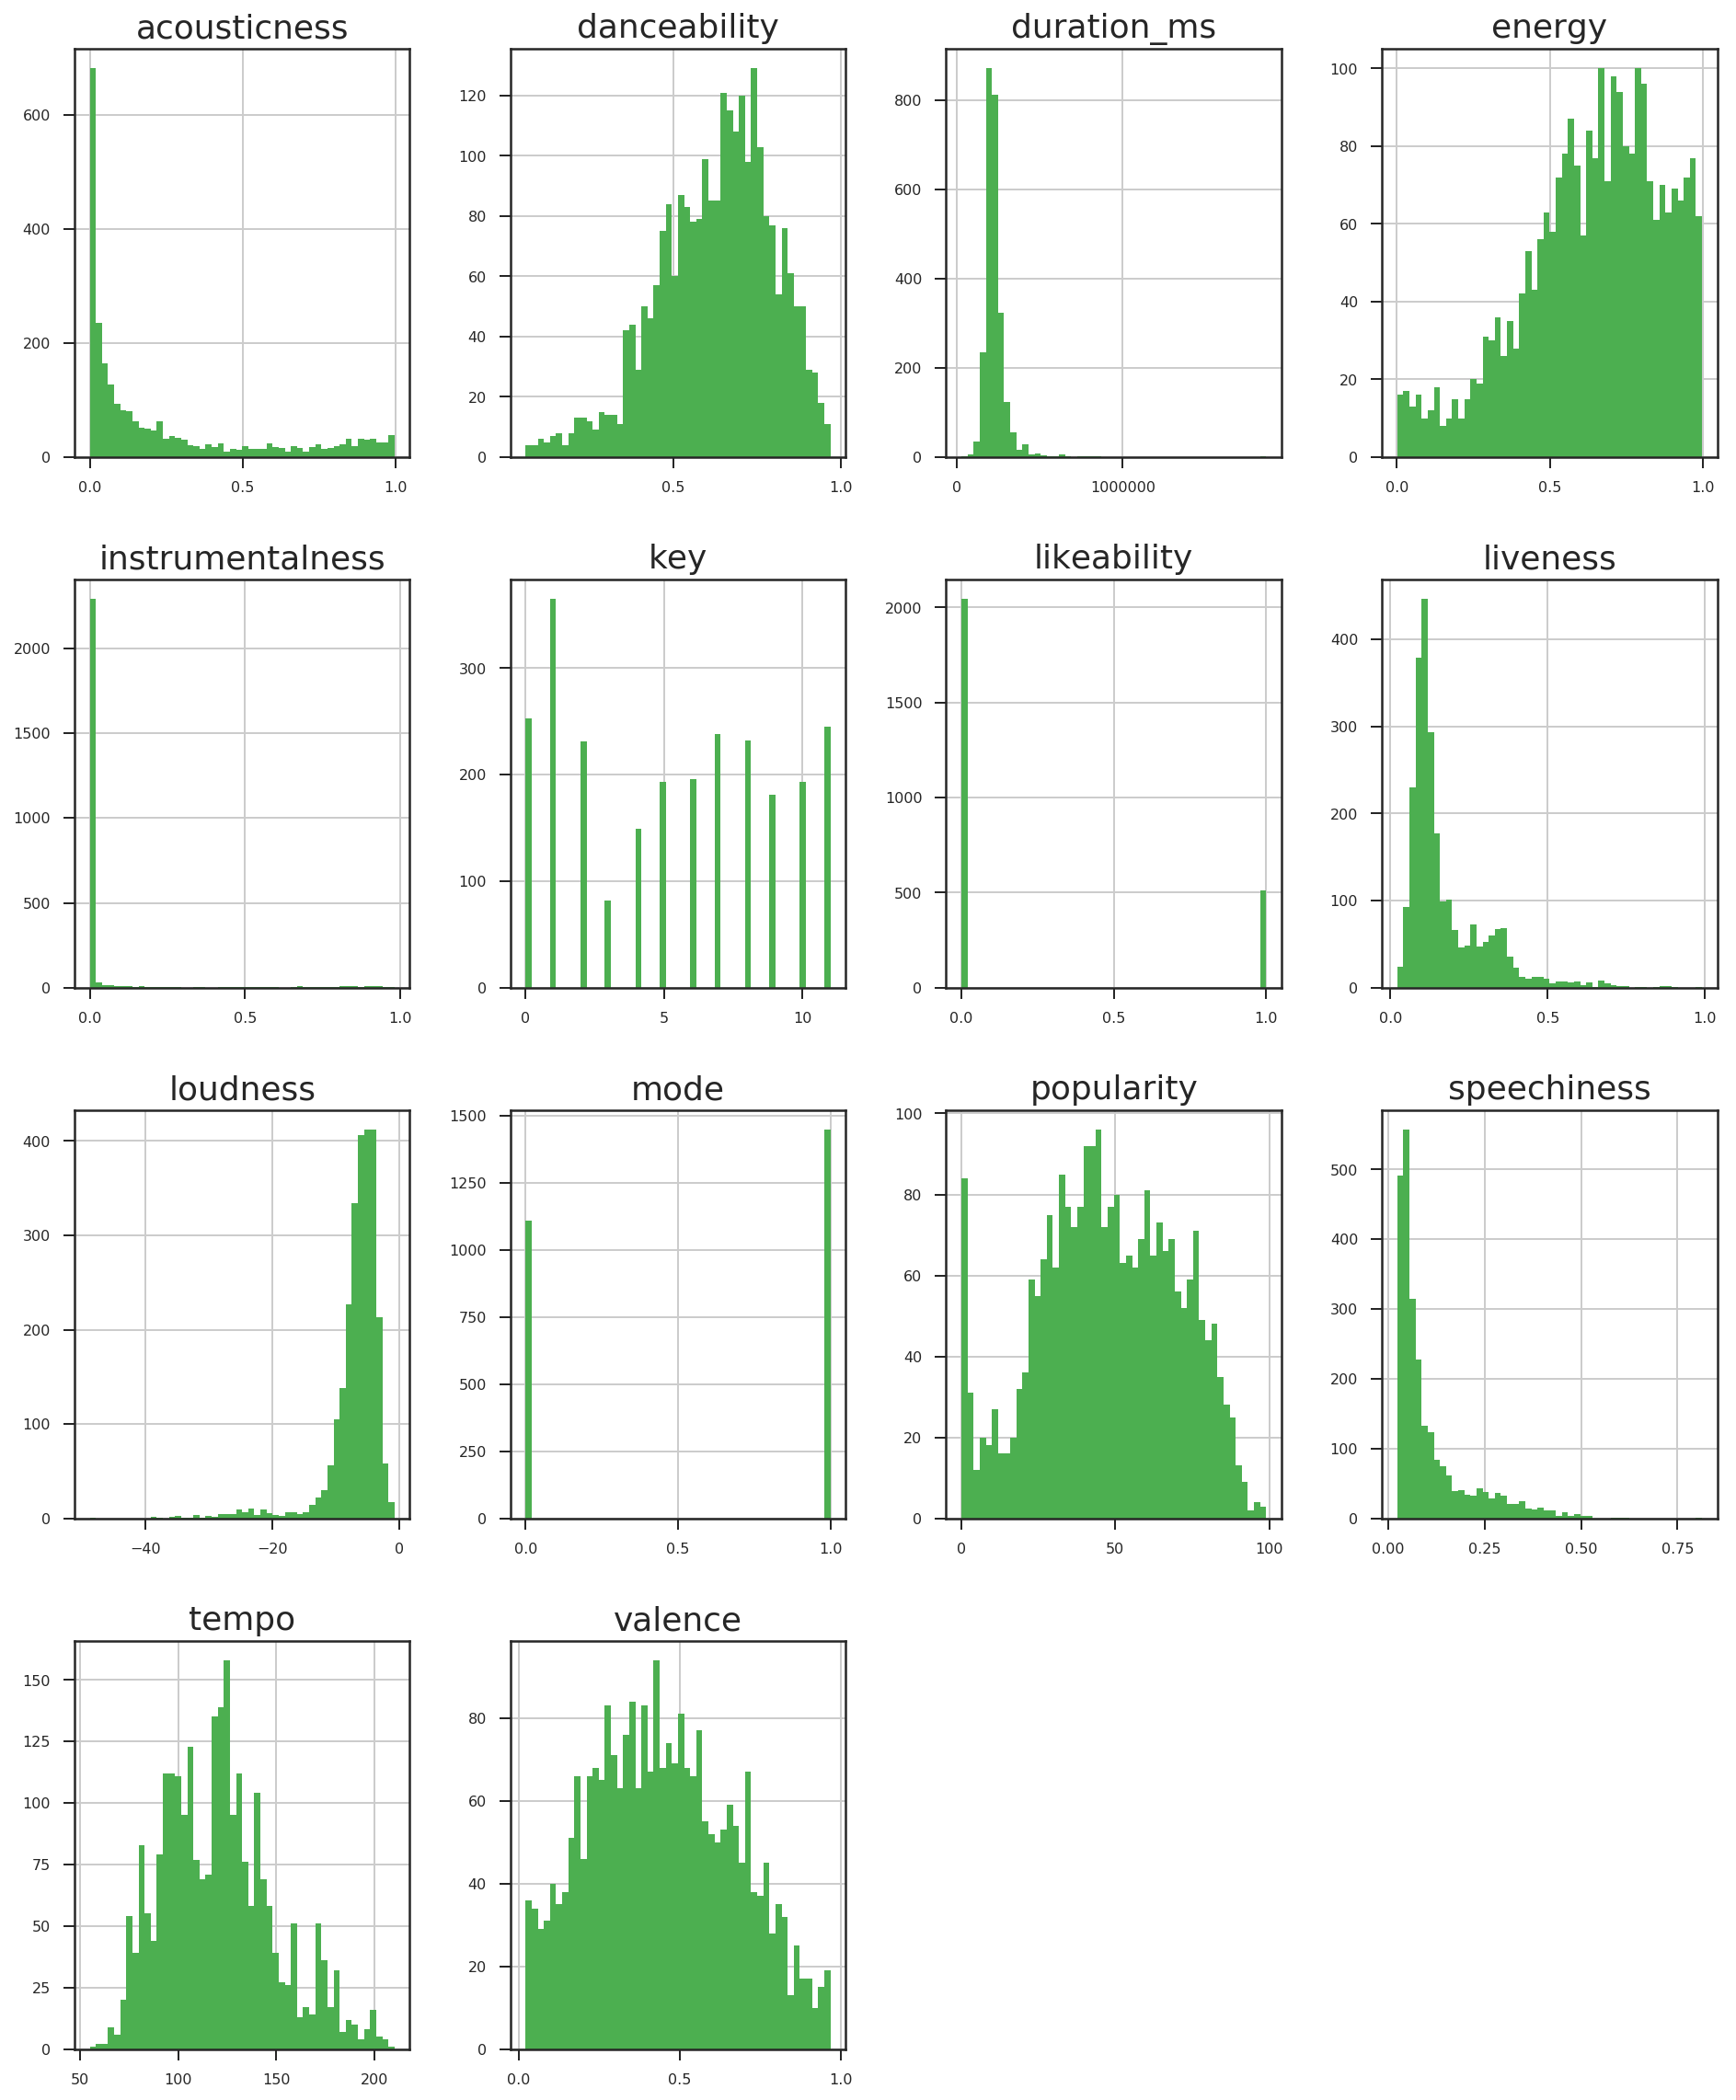

In [175]:
data.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

### Data Cleaning

#### Drop irrelevant columns

In [176]:
columns = ['id', 'name', 'mode', 'instrumentalness']
c_data = data.drop(columns, axis=1)
pprint("Columns deleted: {}".format(columns))
c_data.head(5)

"Columns deleted: ['id', 'name', 'mode', 'instrumentalness']"


popularity 
 acousticness 
 danceability 
 duration_ms 
 energy 
 key 
 liveness 
 loudness 
 speechiness 
 tempo 
 valence 
 genre 
 likeability 
 
 
 
 
 36 
 25 
 0.00634 
 0.754 
 178570 
 0.838 
 6 
 0.0644 
 -2.980 
 0.0647 
 127.983 
 0.118 
 techno 
 0 
 
 
 115 
 67 
 0.49900 
 0.621 
 186293 
 0.247 
 11 
 0.1130 
 -12.291 
 0.0393 
 111.974 
 0.221 
 rap 
 1 
 
 
 313 
 40 
 0.03770 
 0.768 
 192284 
 0.501 
 9 
 0.1250 
 -5.803 
 0.1630 
 150.109 
 0.394 
 dance 
 0 
 
 
 90 
 80 
 0.28200 
 0.651 
 218763 
 0.568 
 5 
 0.0862 
 -6.774 
 0.0275 
 93.006 
 0.805 
 rock 
 0 
 
 
 0 
 91 
 0.04170 
 0.801 
 163253 
 0.795 
 1 
 0.0717 
 -5.115 
 0.0504 
 79.028 
 0.754 
 jazz 
 0

#### Drop rows with < 30% NaN values

In [177]:
c_data = c_data[[column for column in c_data if c_data[column].count() / len(c_data) >= 0.3]]
c_data.shape

(2558, 13)

#### Convert labels to numerical categories

In [178]:
c_data.genre = pd.Categorical(c_data.genre)
c_data['genre'] = c_data.genre.cat.codes
c_data.head(5)

popularity 
 acousticness 
 danceability 
 duration_ms 
 energy 
 key 
 liveness 
 loudness 
 speechiness 
 tempo 
 valence 
 genre 
 likeability 
 
 
 
 
 36 
 25 
 0.00634 
 0.754 
 178570 
 0.838 
 6 
 0.0644 
 -2.980 
 0.0647 
 127.983 
 0.118 
 11 
 0 
 
 
 115 
 67 
 0.49900 
 0.621 
 186293 
 0.247 
 11 
 0.1130 
 -12.291 
 0.0393 
 111.974 
 0.221 
 8 
 1 
 
 
 313 
 40 
 0.03770 
 0.768 
 192284 
 0.501 
 9 
 0.1250 
 -5.803 
 0.1630 
 150.109 
 0.394 
 3 
 0 
 
 
 90 
 80 
 0.28200 
 0.651 
 218763 
 0.568 
 5 
 0.0862 
 -6.774 
 0.0275 
 93.006 
 0.805 
 9 
 0 
 
 
 0 
 91 
 0.04170 
 0.801 
 163253 
 0.795 
 1 
 0.0717 
 -5.115 
 0.0504 
 79.028 
 0.754 
 5 
 0

#### Archive original data and set 'data' to cleaned data

In [179]:
archived, data = data, c_data

#### Segregate Features and Targets

In [180]:
features, targets = data.iloc[:, :-2], data.iloc[:, -2:]

In [181]:
features.head(5)

popularity 
 acousticness 
 danceability 
 duration_ms 
 energy 
 key 
 liveness 
 loudness 
 speechiness 
 tempo 
 valence 
 
 
 
 
 36 
 25 
 0.00634 
 0.754 
 178570 
 0.838 
 6 
 0.0644 
 -2.980 
 0.0647 
 127.983 
 0.118 
 
 
 115 
 67 
 0.49900 
 0.621 
 186293 
 0.247 
 11 
 0.1130 
 -12.291 
 0.0393 
 111.974 
 0.221 
 
 
 313 
 40 
 0.03770 
 0.768 
 192284 
 0.501 
 9 
 0.1250 
 -5.803 
 0.1630 
 150.109 
 0.394 
 
 
 90 
 80 
 0.28200 
 0.651 
 218763 
 0.568 
 5 
 0.0862 
 -6.774 
 0.0275 
 93.006 
 0.805 
 
 
 0 
 91 
 0.04170 
 0.801 
 163253 
 0.795 
 1 
 0.0717 
 -5.115 
 0.0504 
 79.028 
 0.754

In [182]:
targets.head(5)

genre 
 likeability 
 
 
 
 
 36 
 11 
 0 
 
 
 115 
 8 
 1 
 
 
 313 
 3 
 0 
 
 
 90 
 9 
 0 
 
 
 0 
 5 
 0

#### Normalize Features # TODO: DO LOG TRANSFORMATION ON ACOUSTICNESS, LIVENESS, etc.

In [183]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
features = pd.DataFrame(scaled_features, index=features.index, columns=features.columns)
features.head(5)

popularity 
 acousticness 
 danceability 
 duration_ms 
 energy 
 key 
 liveness 
 loudness 
 speechiness 
 tempo 
 valence 
 
 
 
 
 36 
 0.252525 
 0.006360 
 0.762768 
 0.081014 
 0.839522 
 0.545455 
 0.044295 
 0.953606 
 0.052479 
 0.470369 
 0.102902 
 
 
 115 
 0.676768 
 0.501002 
 0.616694 
 0.085226 
 0.246757 
 1.000000 
 0.094476 
 0.759635 
 0.020359 
 0.367414 
 0.211609 
 
 
 313 
 0.404040 
 0.037847 
 0.778144 
 0.088493 
 0.501516 
 0.818182 
 0.106866 
 0.894796 
 0.176783 
 0.612663 
 0.394195 
 
 
 90 
 0.808081 
 0.283129 
 0.649643 
 0.102931 
 0.568716 
 0.454545 
 0.066804 
 0.874568 
 0.005438 
 0.245429 
 0.827968 
 
 
 0 
 0.919192 
 0.041863 
 0.814388 
 0.072662 
 0.796394 
 0.090909 
 0.051833 
 0.909129 
 0.034396 
 0.155536 
 0.774142

In [184]:
# temp['acousticness'] = (1+temp['acousticness'])/2
# temp['acousticness'] = np.log(temp['acousticness'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c9225a2b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0c934151d0>]], dtype=object)

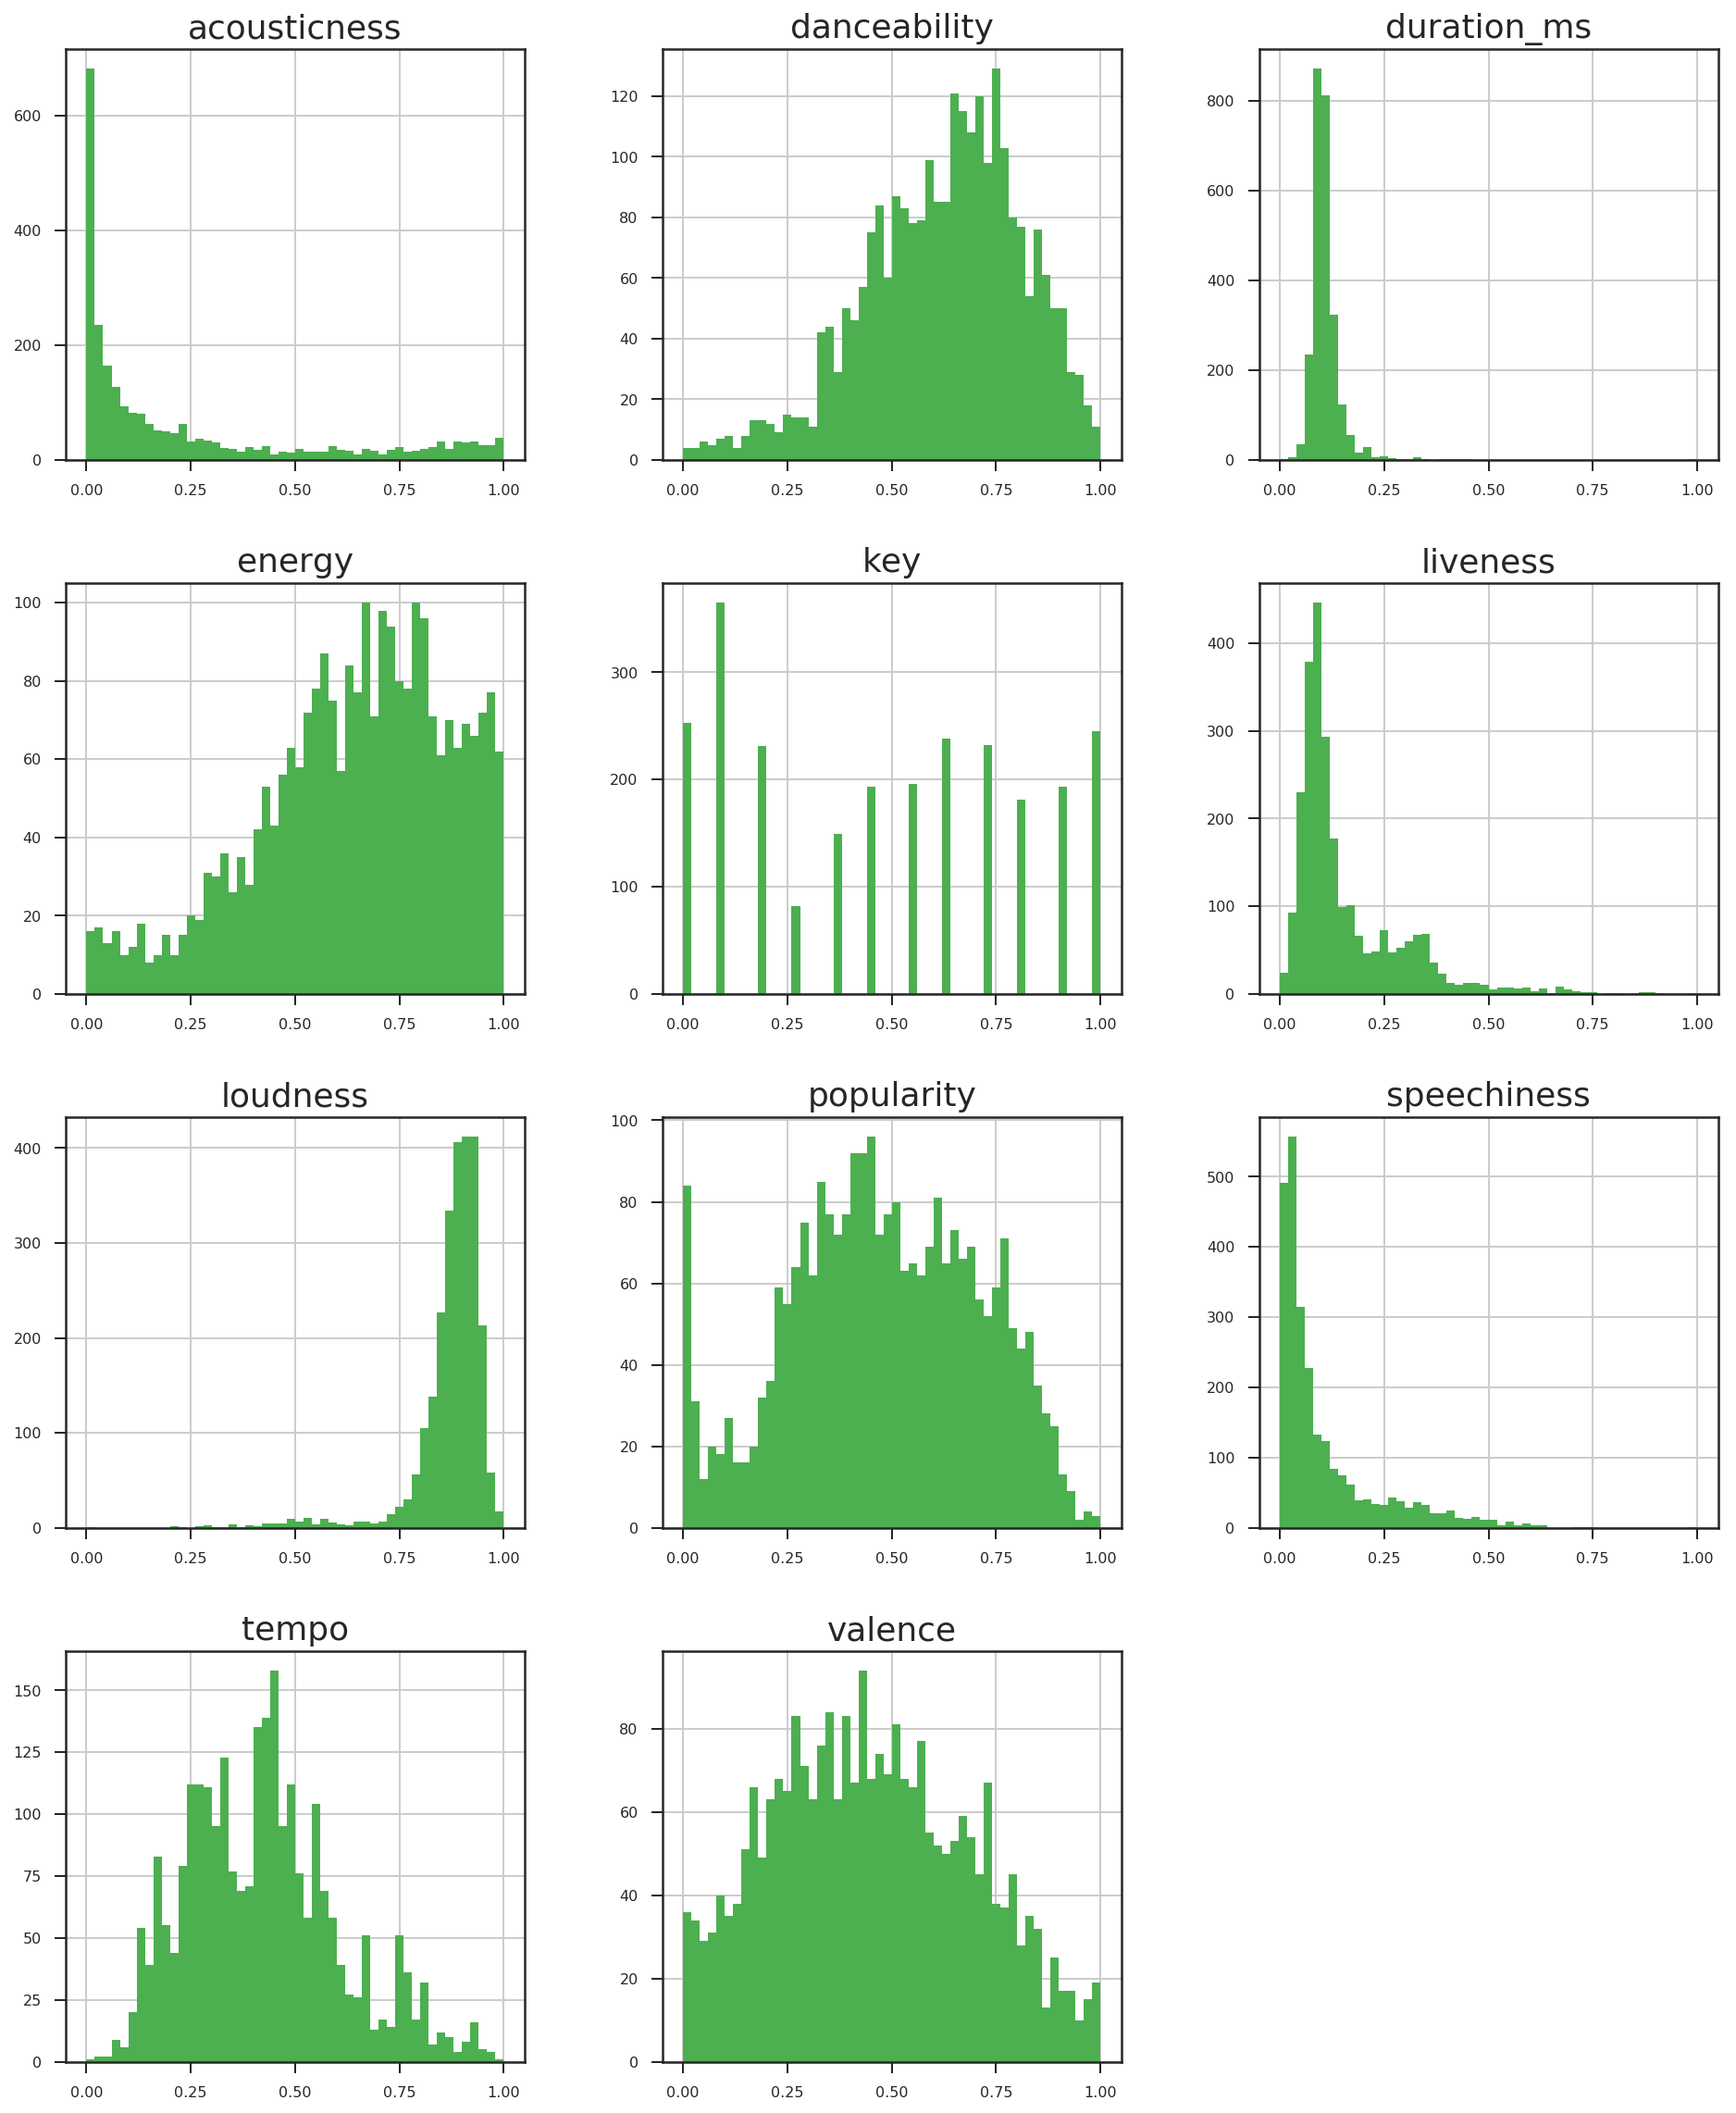

In [185]:
features.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

### Feature Selection

In [186]:
X = features
Y = targets.iloc[:, -1]
names = data.columns.values[:-1]

rfc = RandomForestClassifier()
rfc.fit(X, Y)

print("Features sorted by their score:")
pprint(sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), names), reverse=True))

Features sorted by their score:
[(0.2112, 'speechiness'),
 (0.125, 'danceability'),
 (0.1137, 'tempo'),
 (0.0974, 'valence'),
 (0.094899999999999998, 'acousticness'),
 (0.085599999999999996, 'popularity'),
 (0.085599999999999996, 'energy'),
 (0.057599999999999998, 'liveness'),
 (0.054699999999999999, 'loudness'),
 (0.049200000000000001, 'duration_ms'),
 (0.025100000000000001, 'key')]


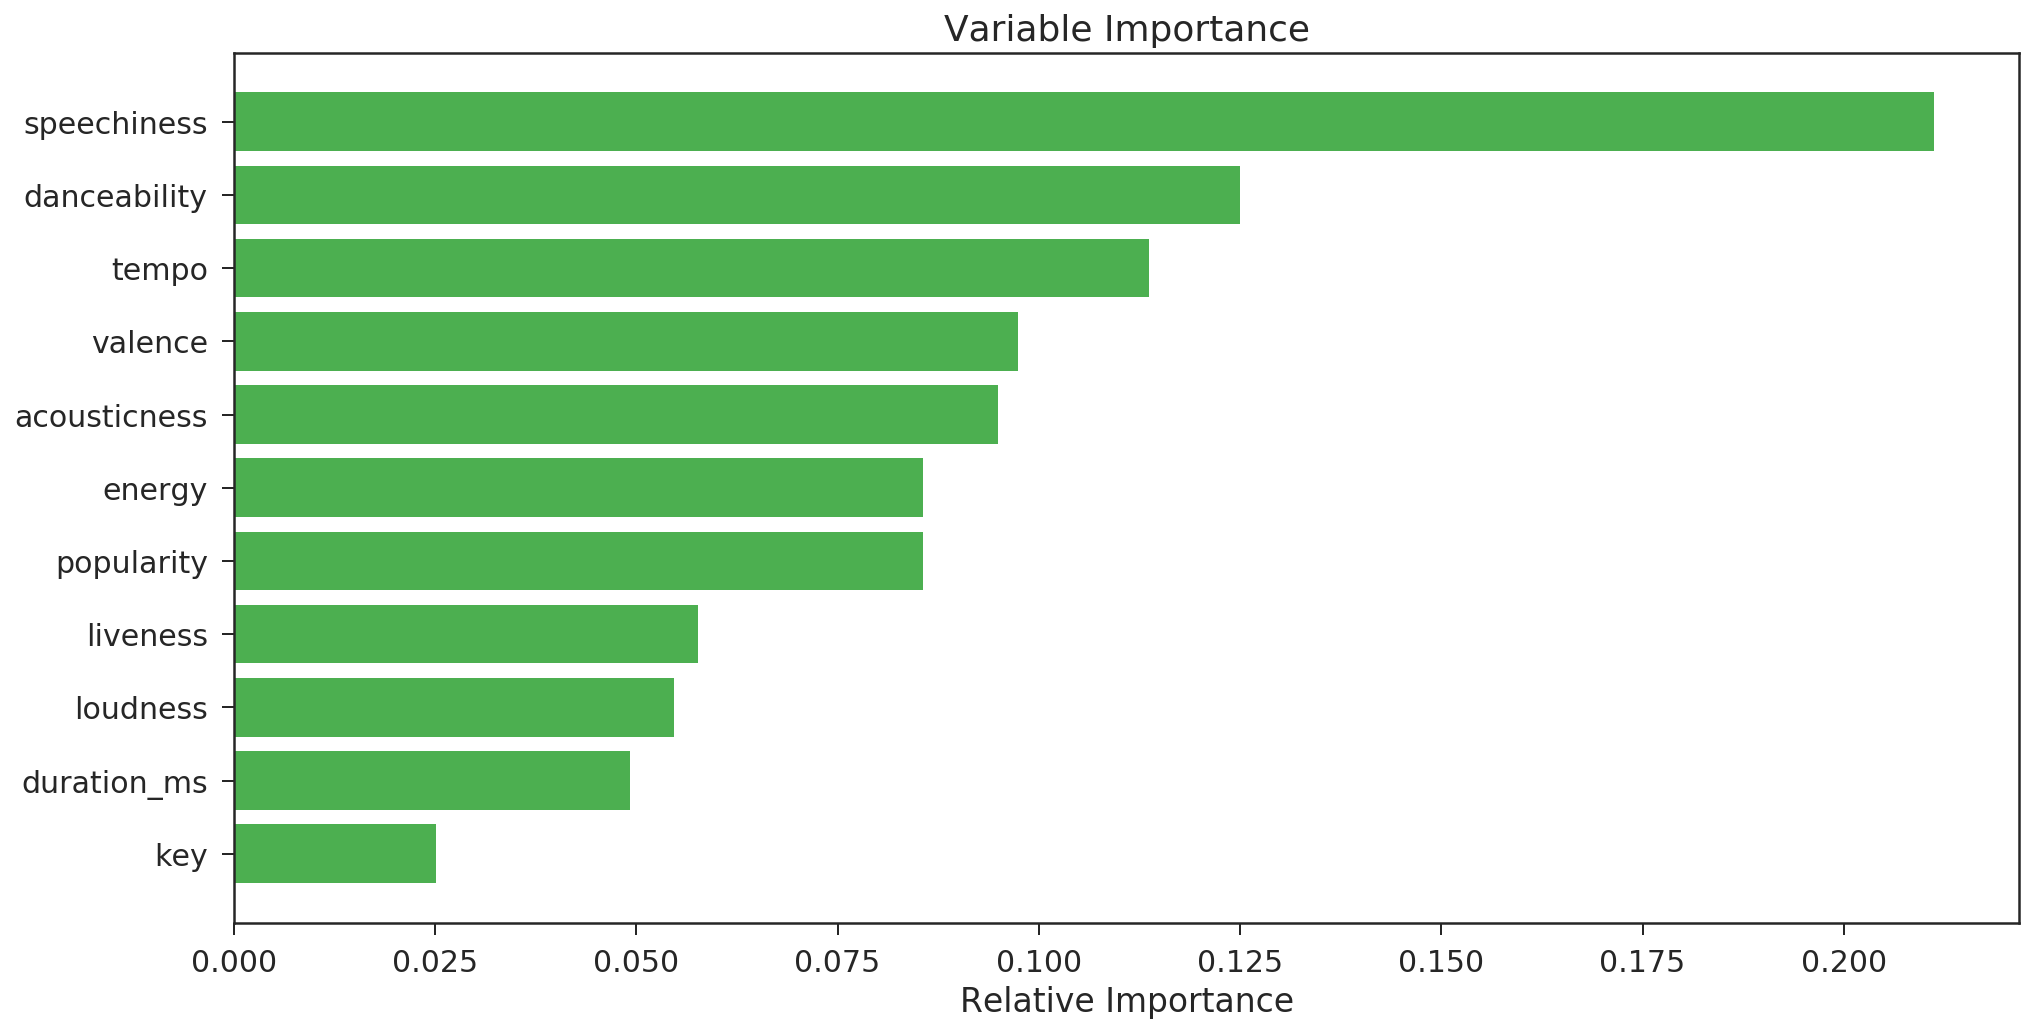

In [187]:
importance = rfc.feature_importances_

sorted_importances = np.argsort(importance)

padding = np.arange(len(names)-1) + 0.5

plt.barh(padding, importance[sorted_importances], align='center')

plt.yticks(padding, names[sorted_importances])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")

plt.show()

### Correlation Identification

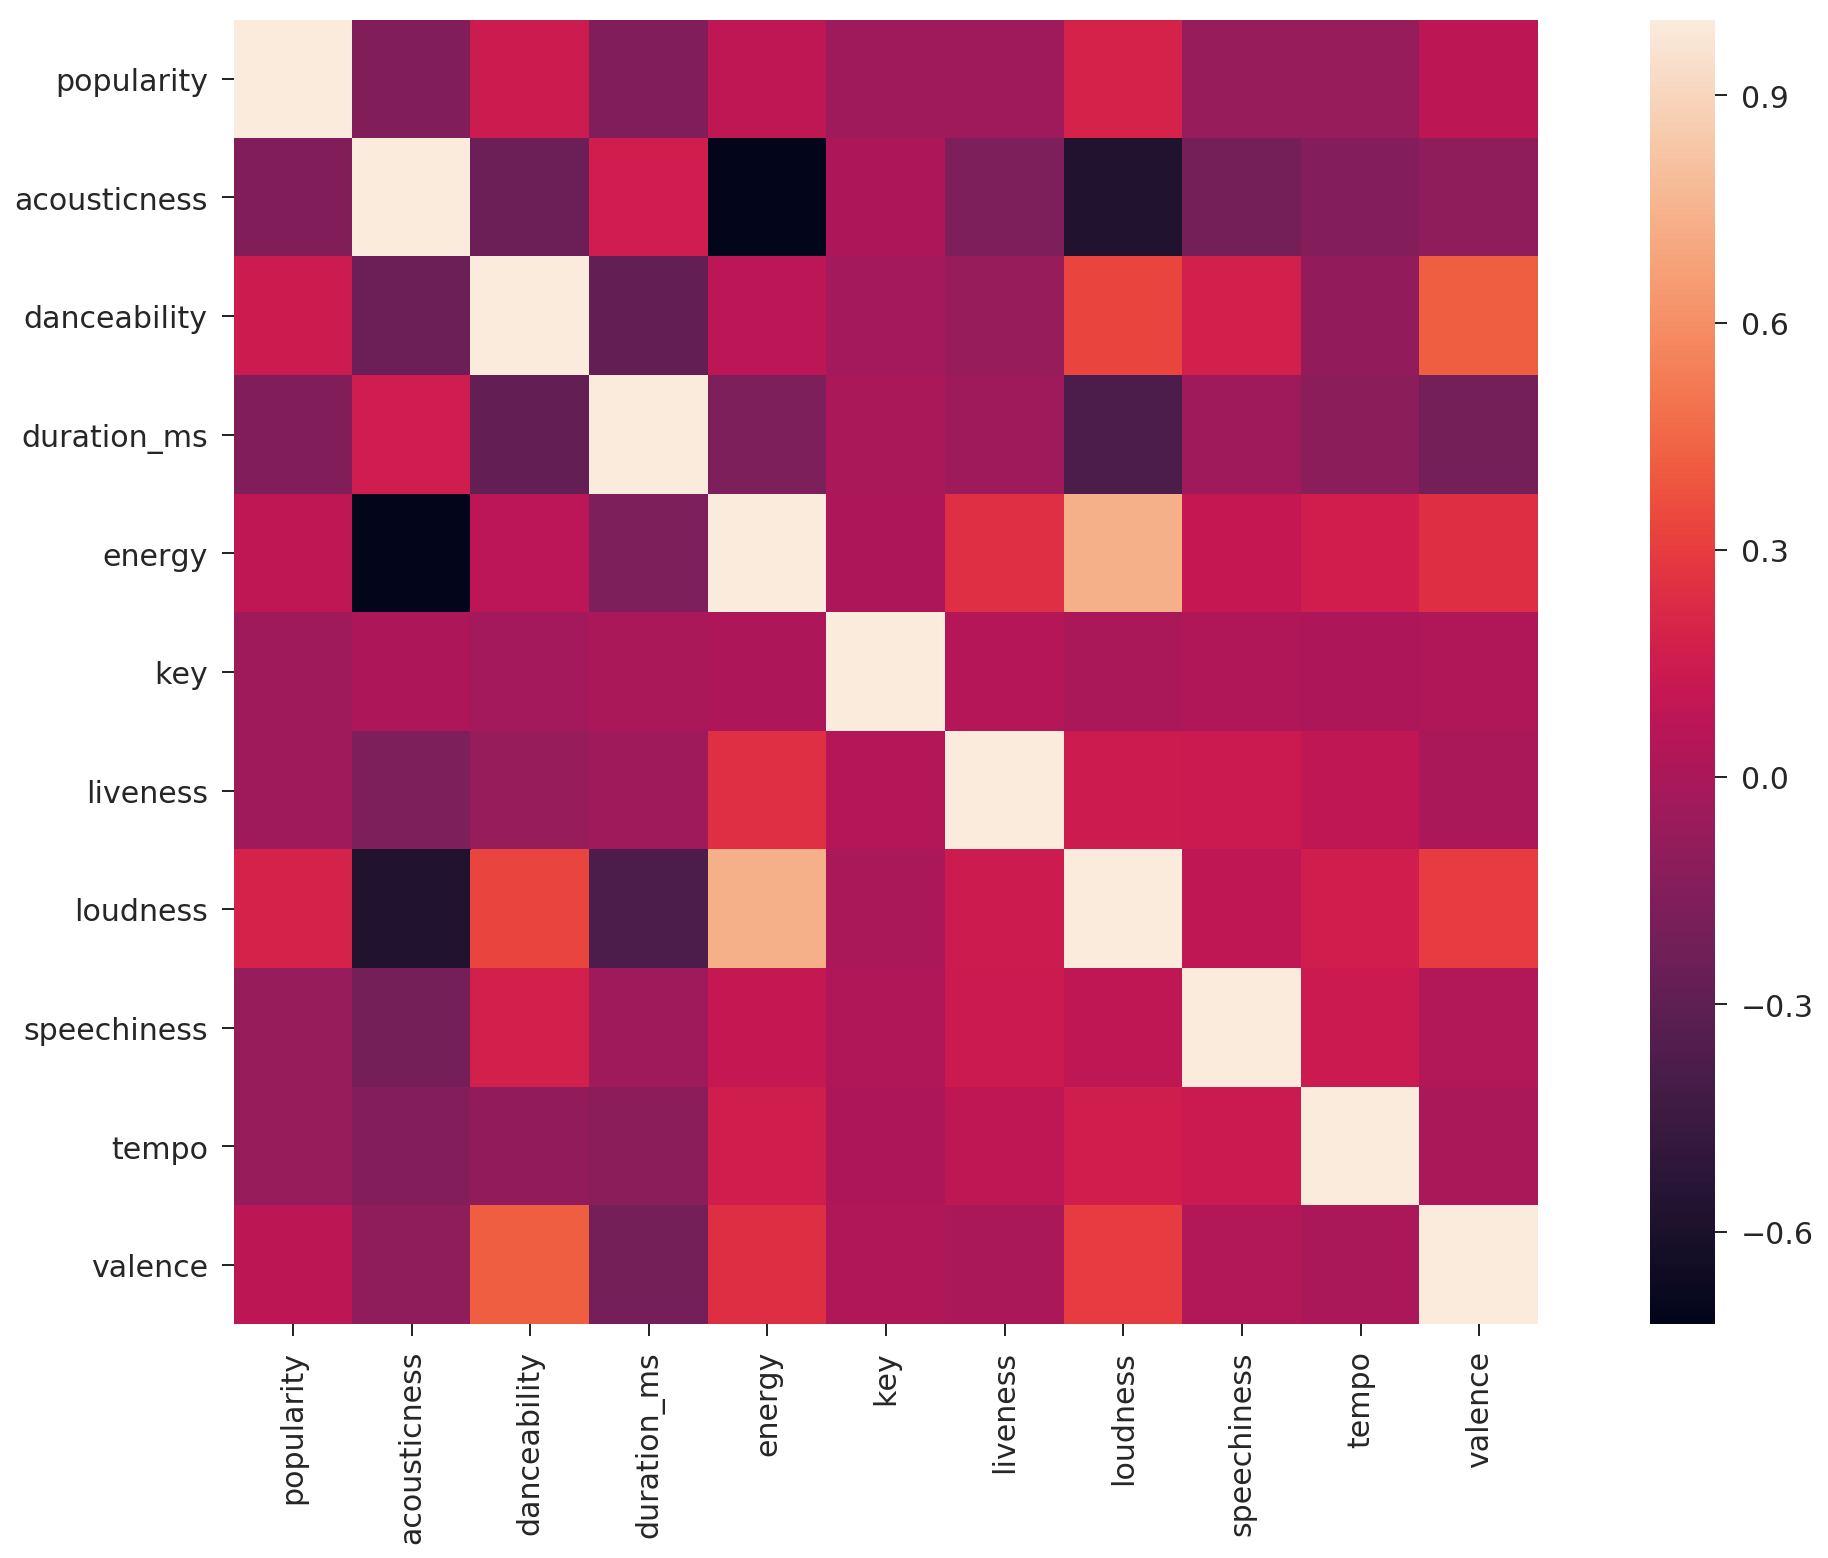

In [188]:
corr_mat = features.corr()
fig, ax = plt.subplots(figsize=(20, 12)) 
sns.heatmap(corr_mat, vmax=1.0, square=True, ax=ax);

In [189]:
corr_mat

popularity 
 acousticness 
 danceability 
 duration_ms 
 energy 
 key 
 liveness 
 loudness 
 speechiness 
 tempo 
 valence 
 
 
 
 
 popularity 
 1.000000 
 -0.160570 
 0.143135 
 -0.162818 
 0.090686 
 -0.045471 
 -0.045800 
 0.189624 
 -0.072582 
 -0.075558 
 0.081334 
 
 
 acousticness 
 -0.160570 
 1.000000 
 -0.251126 
 0.155780 
 -0.722195 
 0.016808 
 -0.170610 
 -0.567914 
 -0.206253 
 -0.144223 
 -0.097372 
 
 
 danceability 
 0.143135 
 -0.251126 
 1.000000 
 -0.284623 
 0.076994 
 -0.024068 
 -0.075627 
 0.328688 
 0.176569 
 -0.091087 
 0.416092 
 
 
 duration_ms 
 -0.162818 
 0.155780 
 -0.284623 
 1.000000 
 -0.171472 
 0.005869 
 -0.037538 
 -0.378118 
 -0.045762 
 -0.112129 
 -0.206227 
 
 
 energy 
 0.090686 
 -0.722195 
 0.076994 
 -0.171472 
 1.000000 
 0.013257 
 0.248623 
 0.732523 
 0.112822 
 0.165049 
 0.245786 
 
 
 key 
 -0.045471 
 0.016808 
 -0.024068 
 0.005869 
 0.013257 
 1.000000 
 0.044778 
 0.001254 
 0.028586 
 0.013473 
 0.021556 
 
 
 liveness 
 -0.045800 
 -0.170610 
 -0.075627 
 -0.037538 
 0.248623 
 0.044778 
 1.000000 
 0.143498 
 0.133805 
 0.087396 
 0.005653 
 
 
 loudness 
 0.189624 
 -0.567914 
 0.328688 
 -0.378118 
 0.732523 
 0.001254 
 0.143498 
 1.000000 
 0.089532 
 0.164398 
 0.298320 
 
 
 speechiness 
 -0.072582 
 -0.206253 
 0.176569 
 -0.045762 
 0.112822 
 0.028586 
 0.133805 
 0.089532 
 1.000000 
 0.135006 
 0.035447 
 
 
 tempo 
 -0.075558 
 -0.144223 
 -0.091087 
 -0.112129 
 0.165049 
 0.013473 
 0.087396 
 0.164398 
 0.135006 
 1.000000 
 -0.000900 
 
 
 valence 
 0.081334 
 -0.097372 
 0.416092 
 -0.206227 
 0.245786 
 0.021556 
 0.005653 
 0.298320 
 0.035447 
 -0.000900 
 1.000000

In [190]:
data.groupby('likeability').mean()

popularity 
 acousticness 
 danceability 
 duration_ms 
 energy 
 key 
 liveness 
 loudness 
 speechiness 
 tempo 
 valence 
 genre 
 
 
 likeability 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 48.590020 
 0.271519 
 0.599487 
 230038.120841 
 0.643501 
 5.329746 
 0.17176 
 -7.004189 
 0.085708 
 119.641721 
 0.458499 
 4.658513 
 
 
 1 
 43.756809 
 0.124390 
 0.740885 
 227694.389105 
 0.623658 
 5.237354 
 0.19050 
 -6.440300 
 0.198710 
 125.034488 
 0.408441 
 8.000000

## Machine Learning

### Training, Cross-validation, Testing data : 60-20-20

In [191]:
x, x_test, y, y_test = train_test_split(features, targets, test_size=0.2, train_size=0.8, shuffle=True)
x_train, x_cv, y_train, y_cv = train_test_split(x, y, test_size = 0.25, train_size=0.75)

### Supervised Learning

#### Recursive Feature Elimination

In [192]:
def rfe_runner(model, x, y, required=3, verbose=True):
    rfe = RFE(model, required)
    rfe = rfe.fit(x, np.array(y).ravel())
    if verbose:
        pprint('RFE Support: {}'.format(rfe.support_))
        pprint('RFE Ranking: {}'.format(rfe.ranking_))
    clmns = list(data.columns.values)
    ranking = np.array(rfe.ranking_)
    inds  = np.where(ranking <=1)
    preferred_features = [clmns[x] for x in inds[0]]
    return preferred_features

#### ROC Calculator

In [193]:
def roc_calc(test, pred):
    fpr, tpr, thresholds = roc_curve(test, pred)
    roc_auc= roc_auc_score(test, pred)
    return fpr, tpr, thresholds, roc_auc

## Precision-Recall Curve Plot

In [194]:
def plot_precision_recall_curve(average_precision, y_score_test,y_test):
    precision, recall, _ = precision_recall_curve(y_test, y_score_test)

    plt.step(recall, precision, color='b', alpha=0.2,where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

#### Logistic Regression

In [246]:
def logreg_runner(x, y, parameters, verbose=True):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=random_state)
    logreg = linear_model.LogisticRegression(C=1.0)
    clf = GridSearchCV(logreg, parameters, n_jobs=5, scoring='average_precision')
    clf.fit(X_train,y_train)
    z = clf.best_estimator_
    y_pred_logreg = z.predict_proba(X_test)
    y_pred = z.predict(X_test)
    fpr, tpr, thresholds, roc_auc = roc_calc(y_test, y_pred_logreg[:,1])
    y_score_train = z.decision_function(X_train)
    y_score_test = z.decision_function(X_test)
    if verbose:
        pprint('Best params: {}'.format(clf.best_params_))
        pprint('Accuracy score of Logistic Regression on test set: {:.2f}'.format(accuracy_score(y_test,y_pred)))
        pprint('ROC AUC: {}'.format(roc_auc))
        plot_precision_recall_curve(average_precision_score(y_test,y_score_test), y_score_test,y_test)
    return fpr, tpr, roc_auc

##### All features

In [247]:
X = features
Y = targets['likeability']

In [248]:
params = {
    'C': [1]
}

"Best params: {'C': 1}"
'Acuracy score of Logistic Regression on test set: 0.86'
'ROC AUC: 0.8888859511823681'


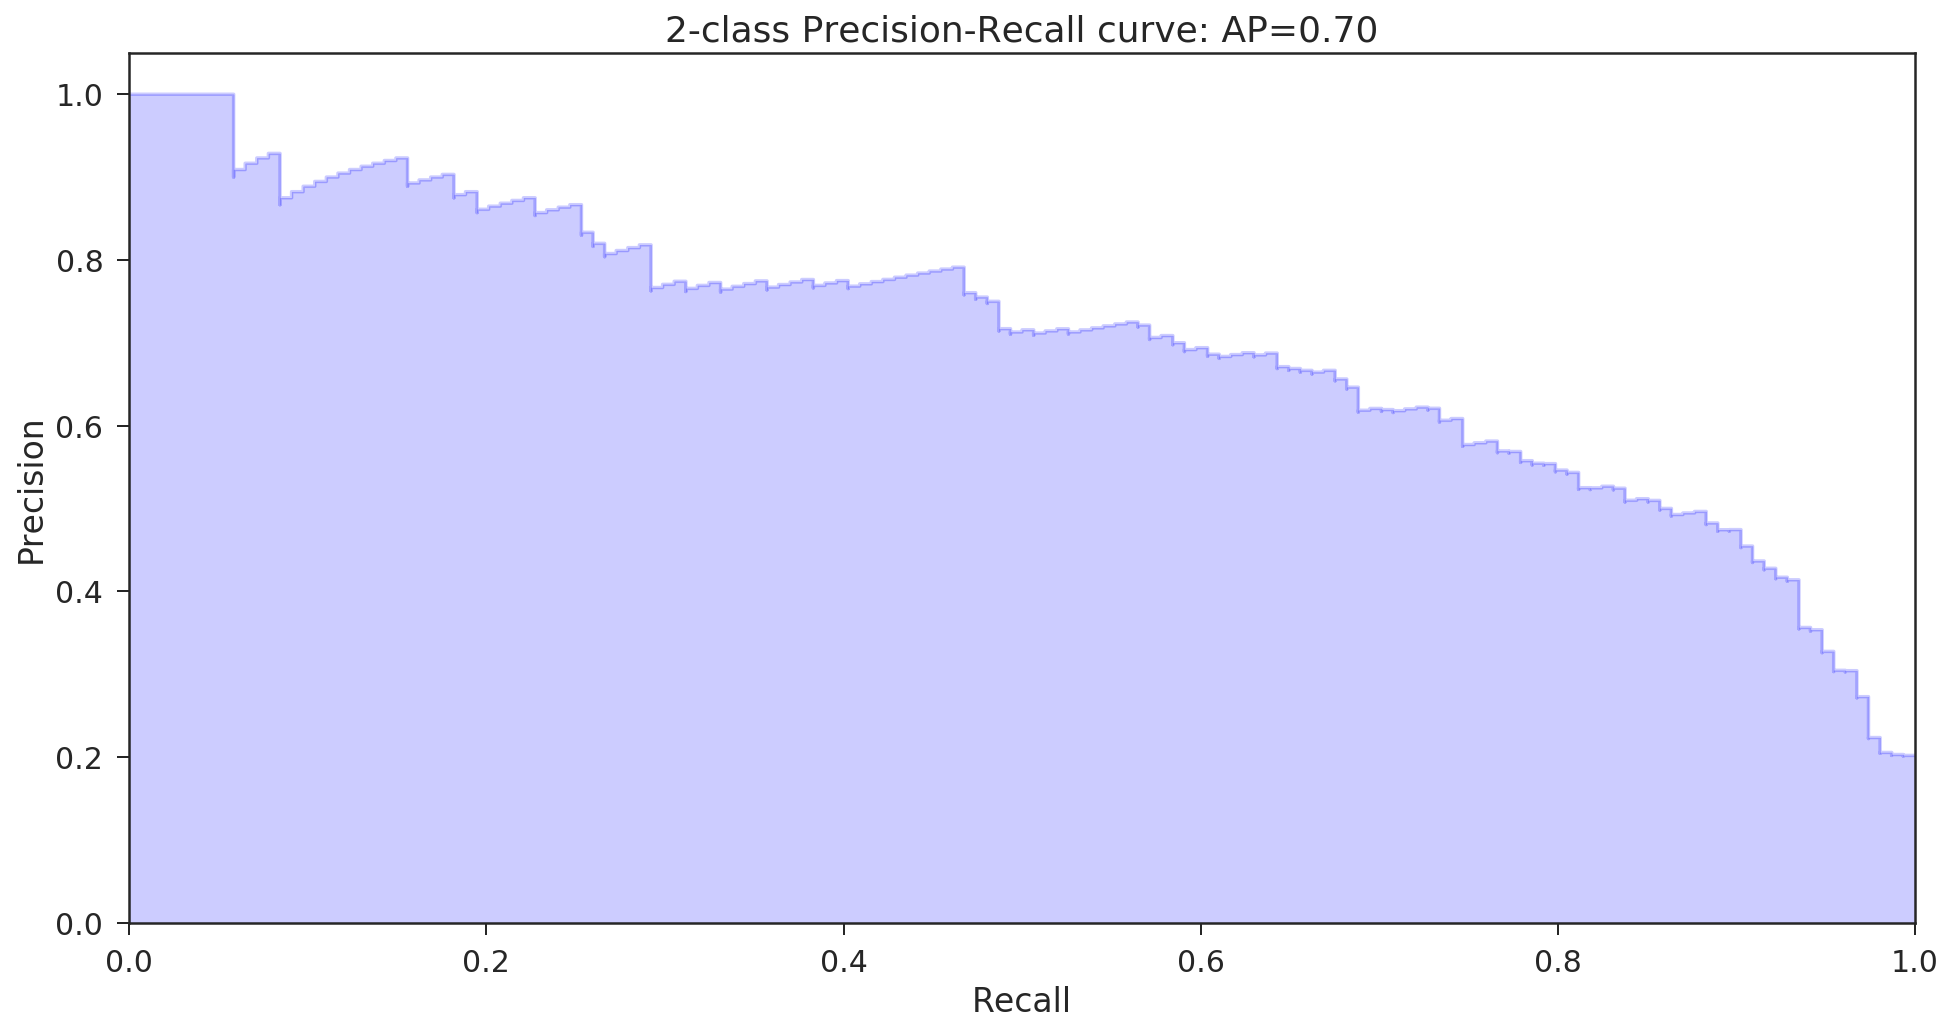

In [249]:
logreg_all_fpr, logreg_all_tpr, logreg_all_roc_auc = logreg_runner(X, Y, params, verbose=True)

##### Preferred features

In [199]:
logreg = linear_model.LogisticRegression(C=1.0)
preferred_features = rfe_runner(logreg, features, targets['likeability'], required=4, verbose=True)
preferred_features

('RFE Support: [False  True  True False False False False False  True False  '
 'True]')
'RFE Ranking: [3 1 1 6 2 7 4 8 1 5 1]'


['acousticness', 'danceability', 'speechiness', 'valence']

In [200]:
X = features[preferred_features]
Y = targets['likeability']

In [201]:
params = {
    'C': [1]
}

"Best params: {'C': 1}"
'Best estimator score: 0.6554087283830593'
'Average Precision-Recall score of Logistic Regression on train set: 0.65'
'Average Precision-Recall score of Logistic Regression on test set: 0.69'
'Acuracy score of Logistic Regression on test set: 0.85'
'ROC AUC: 0.8739847286264224'


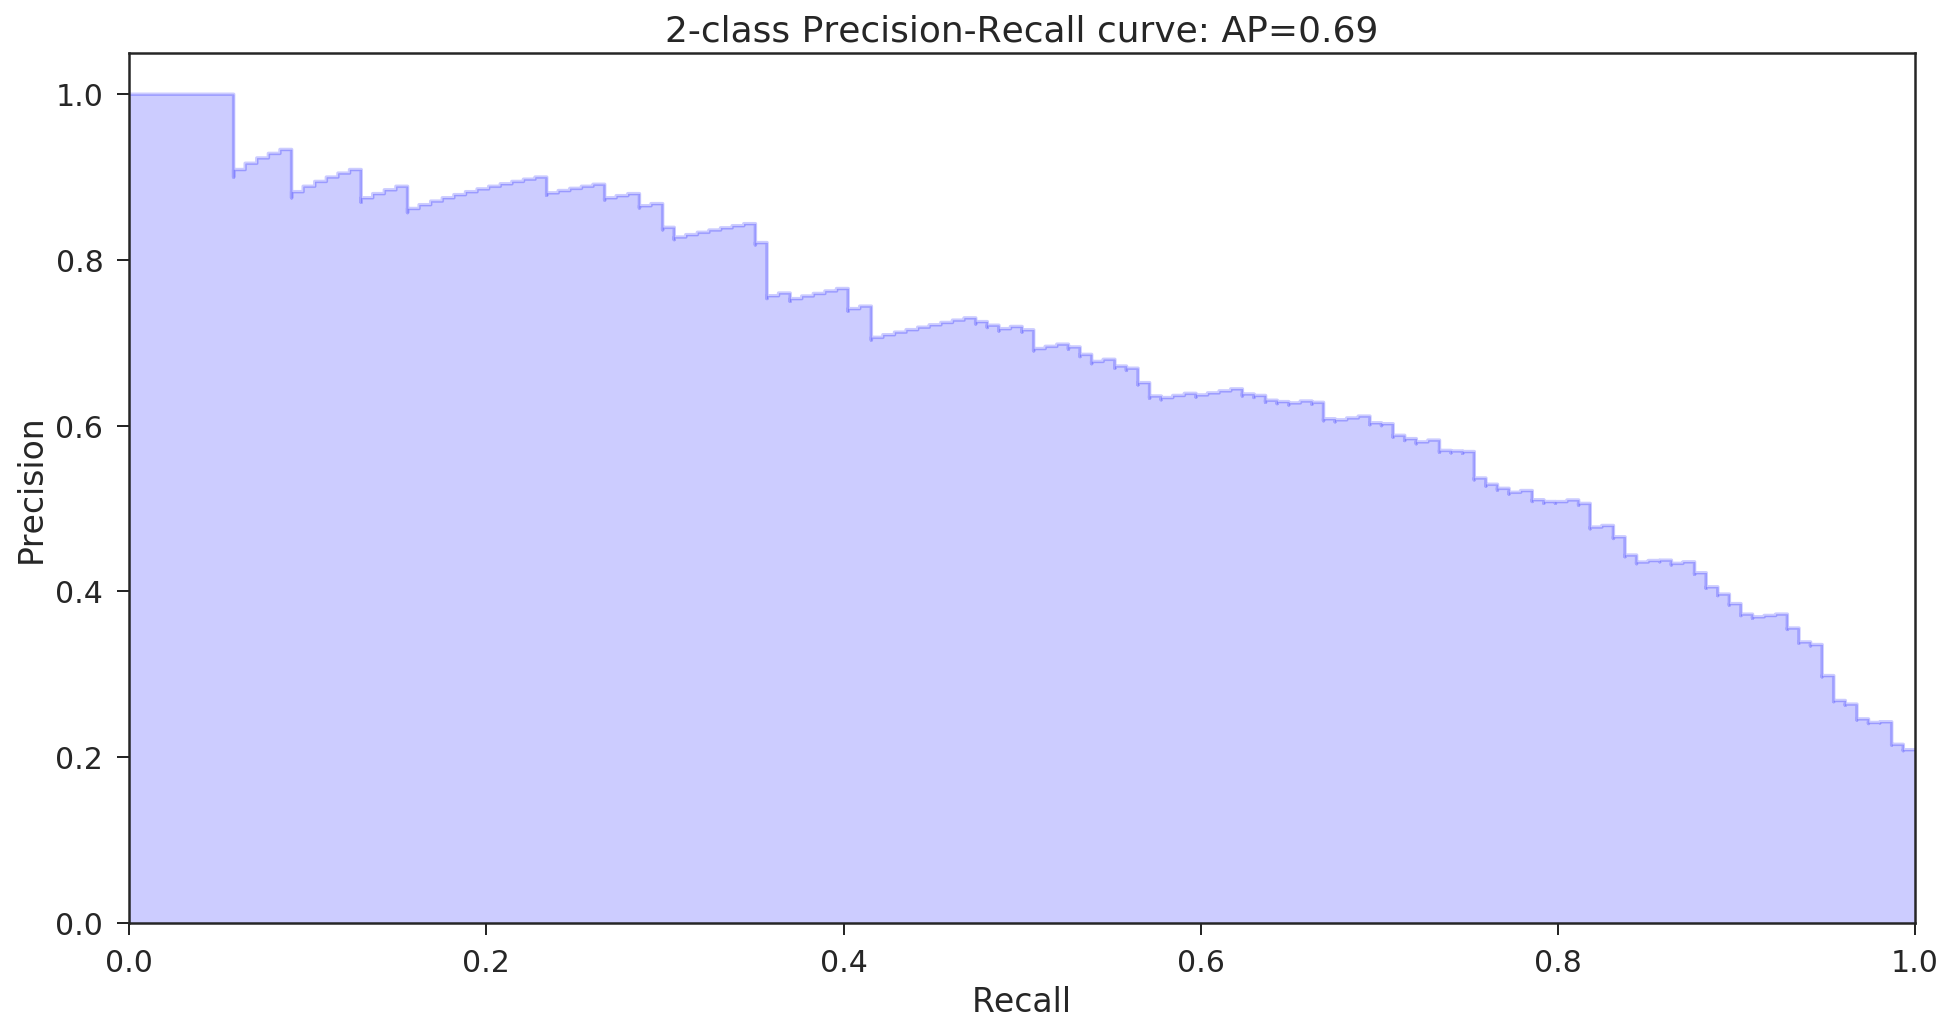

In [202]:
logreg_pref_fpr, logreg_pref_tpr, logreg_pref_roc_auc = logreg_runner(X, Y, params, verbose=True)

#### Random Forests

In [203]:
def rfc_runner(x, y, parameters, verbose=True):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=random_state)
    rfc = RandomForestClassifier()
    clf = RandomizedSearchCV(rfc, parameters, n_jobs=-1, scoring='average_precision')
    clf.fit(X_train,y_train)
    z = clf.best_estimator_
    y_pred_logreg = z.predict_proba(X_test)
    y_pred = z.predict(X_test)
    fpr, tpr, thresholds, roc_auc = roc_calc(y_test, y_pred_logreg[:,1])
    if verbose:
        pprint('Best params: {}'.format(clf.best_params_))
        pprint('Best Features: {}'.format(z.feature_importances_))
        pprint('Best estimator score: {}'.format(clf.best_score_))
        pprint('Accuracy of Random Forests on train set: {:.2f}'.format(z.score(X_train,y_train)))
        pprint('Accuracy of Random Forests on test set: {:.2f}'.format(accuracy_score(y_test,y_pred)))
        pprint('ROC AUC: {}'.format(roc_auc))
    return fpr, tpr, roc_auc

##### All features

In [204]:
X = features
Y = targets['likeability']

In [205]:
params = {
    'n_estimators':[10,30,40,50,100],
    'max_features':['auto','sqrt','log2']
}

In [206]:
rfc_all_fpr, rfc_all_tpr, rfc_all_roc_auc = rfc_runner(X, Y, params, verbose=True)

"Best params: {'max_features': 'sqrt', 'n_estimators': 100}"
('Best Features: [ 0.07293459  0.08013469  0.14152418  0.05875685  0.08748844  '
 '0.02882099\n'
 '  0.05586264  0.05854929  0.22300866  0.09474451  0.09817516]')
'Best estimator score: 0.7070115437872065'
'Accuracy of Random Forests on train set: 1.00'
'Accuracy of Random Forests on test set: 0.88'
'ROC AUC: 0.9141989931892212'


##### Preferred features

In [207]:
rfc = RandomForestClassifier()
preferred_features = rfe_runner(rfc, features, targets['likeability'], required=4, verbose=True)
preferred_features

('RFE Support: [False False  True False False False False False  True  True  '
 'True]')
'RFE Ranking: [4 3 1 6 2 8 7 5 1 1 1]'


['danceability', 'speechiness', 'tempo', 'valence']

In [208]:
X = features[preferred_features]
Y = targets['likeability']

In [209]:
params = {
    'n_estimators':[10,30,40,50,100],
    'max_features':['auto','sqrt','log2']
}

In [210]:
rfc_pref_fpr, rfc_pref_tpr, rfc_pref_roc_auc = rfc_runner(X, Y, params, verbose=True)

"Best params: {'max_features': 'auto', 'n_estimators': 100}"
'Best Features: [ 0.267403    0.3250947   0.20393708  0.20356522]'
'Best estimator score: 0.6828638893813309'
'Accuracy of Random Forests on train set: 1.00'
'Accuracy of Random Forests on test set: 0.86'
'ROC AUC: 0.8934282330047801'


#### Support Vector Machines

In [211]:
def svm_runner(x, y, parameters, kernel='linear', verbose=True):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=random_state)
    svc = SVC(kernel=kernel, probability = True)
    clf = GridSearchCV(svc, parameters, n_jobs =5, scoring='average_precision')
    clf.fit(X_train,y_train)
    z = clf.best_estimator_
    y_pred_svc = z.predict_proba(X_test)
    y_pred = z.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_svc[:,1])
    roc_auc= roc_auc_score(y_test, y_pred_svc[:,1])
    y_score_train = z.decision_function(X_train)
    y_score_test = z.decision_function(X_test)
    if verbose:
        print("KERNEL: {}".format(kernel))
        pprint('Best params: {}'.format(clf.best_params_))
        pprint('Best estimator score: {}'.format(clf.best_score_))
        pprint('Average Precision-recall score of Support Vector classifier on train set: {:.2f}'.format(average_precision_score(y_train,y_score_train)))
        pprint('Average Precision-recall score of Support Vector classifier on test set: {:.2f}'.format(average_precision_score(y_test,y_score_test)))
        pprint('Acuracy score of Support Vector Classifier on test set: {:.2f}'.format(accuracy_score(y_test,y_pred)))
        pprint('ROC AUC: {}'.format(roc_auc))
        plot_precision_recall_curve(average_precision_score(y_test,y_score_test), y_score_test,y_test)
    return fpr, tpr, roc_auc,z

In [212]:
svc = SVC(kernel='linear', probability = True)
preferred_features = rfe_runner(svc, features, targets['likeability'], required=3, verbose=True)
preferred_features

('RFE Support: [False False  True False False False False False  True False  '
 'True]')
'RFE Ranking: [7 2 1 5 3 9 8 4 1 6 1]'


['danceability', 'speechiness', 'valence']

##### Linear Kernel - All features

In [213]:
X = features
Y = targets['likeability']

In [214]:
params = {
    'C':[1.0,10.0,100.0]
}

In [215]:
kernel='linear'

KERNEL: linear
"Best params: {'C': 100.0}"
'Best estimator score: 0.6754145134916913'
'Average Precision-recall score of Support Vector classifier on train set: 0.69'
'Average Precision-recall score of Support Vector classifier on test set: 0.71'
'Acuracy score of Support Vector Classifier on test set: 0.87'
'ROC AUC: 0.8925292948094251'


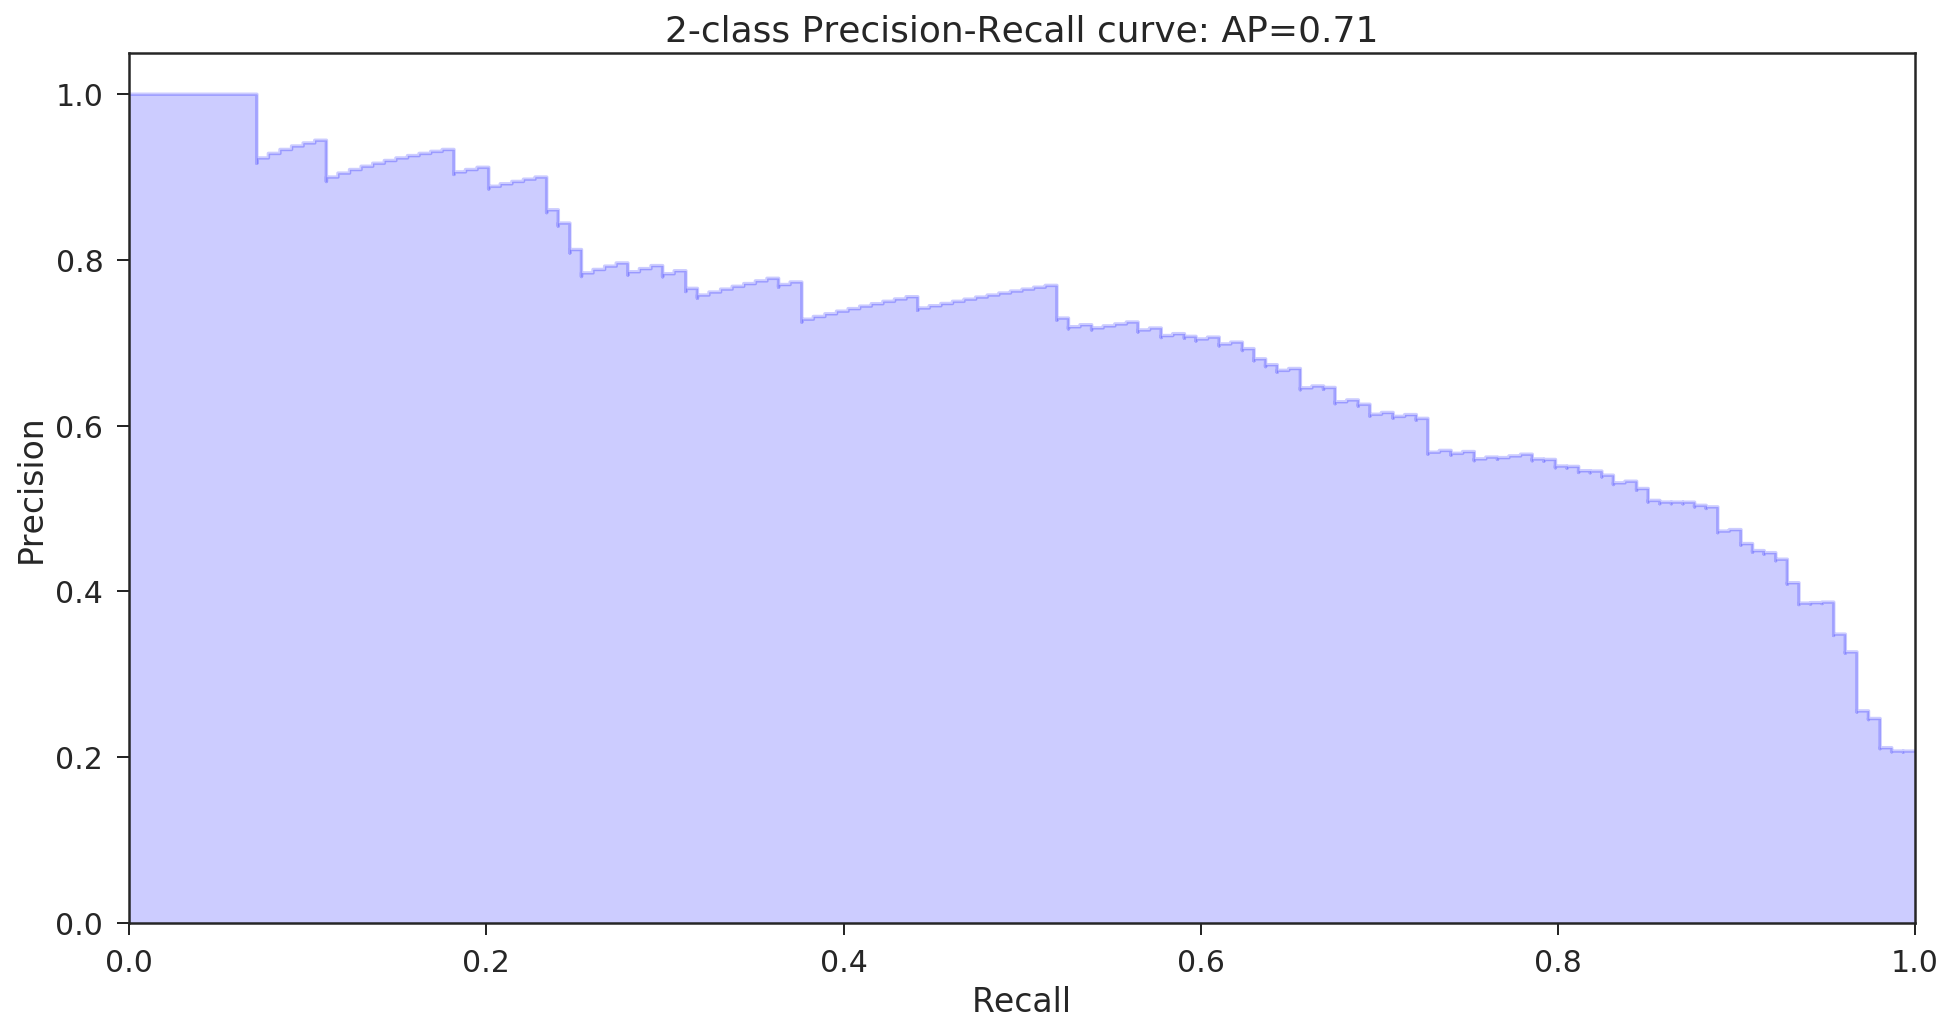

In [216]:
linear_all_fpr, linear_all_tpr, linear_all_roc_auc,clf = svm_runner(X, Y, params, kernel=kernel, verbose=True)

##### Linear Kernel - Preferred features

In [217]:
A = features[['danceability','speechiness']]
B = targets['likeability']
print(preferred_features)

['danceability', 'speechiness', 'valence']


In [218]:
params = {
    'C':[1.0,10.0,100.0]
}

In [219]:
kernel = 'linear'

KERNEL: linear
"Best params: {'C': 10.0}"
'Best estimator score: 0.5768593602753092'
'Average Precision-recall score of Support Vector classifier on train set: 0.58'
'Average Precision-recall score of Support Vector classifier on test set: 0.59'
'Acuracy score of Support Vector Classifier on test set: 0.84'
'ROC AUC: 0.8533408773636787'


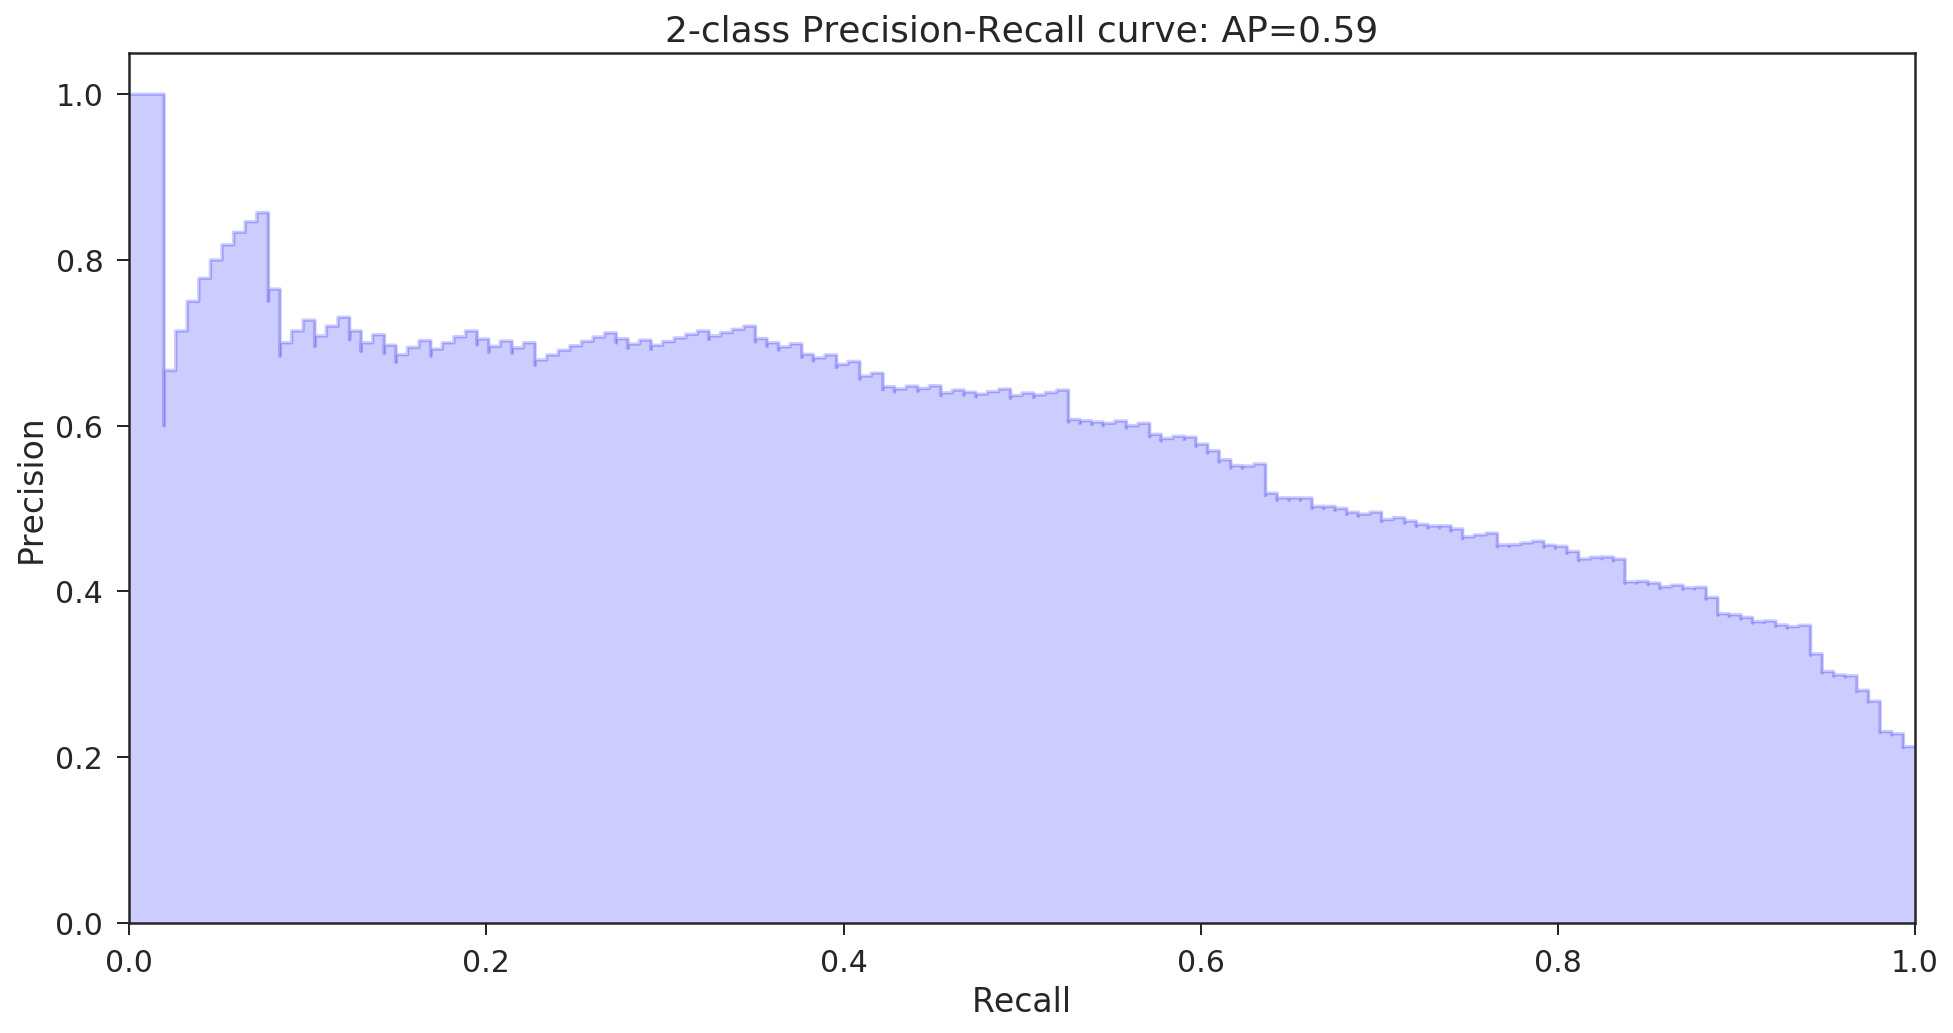

In [220]:
linear_pref_fpr, linear_pref_tpr, linear_pref_roc_auc,clf = svm_runner(A, B, params, kernel=kernel, verbose=True)

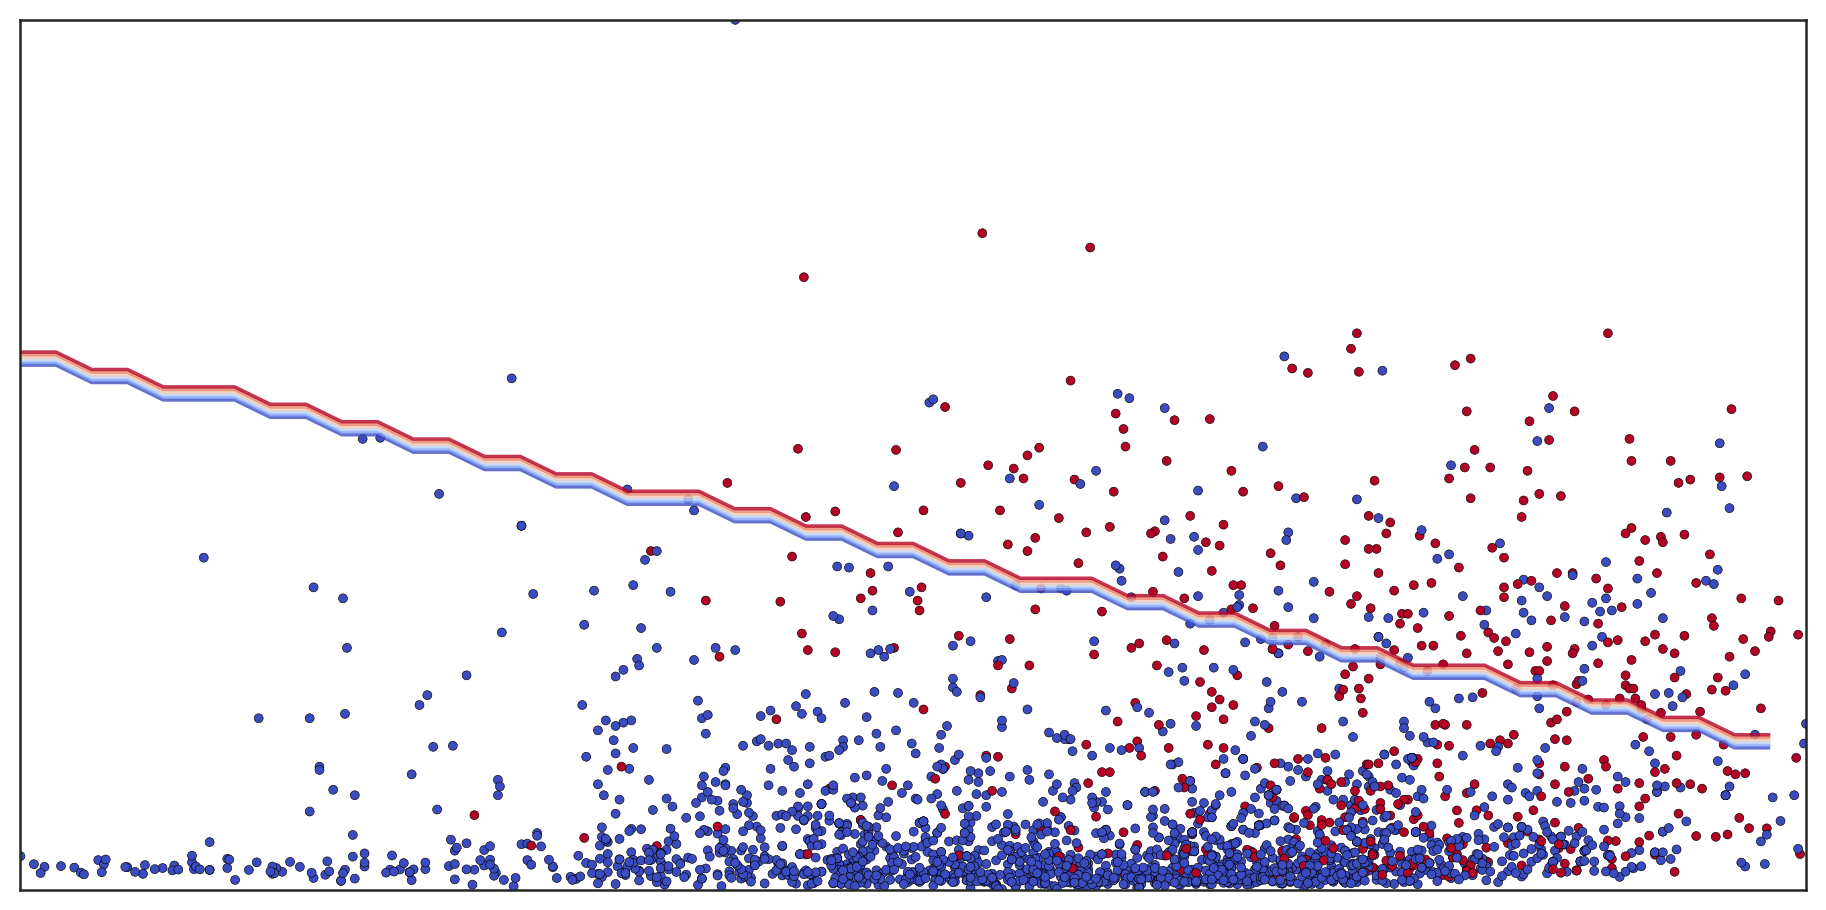

In [221]:
# trying to plot svm results with best estimator
from mpl_toolkits.mplot3d import Axes3D

def make_meshgrid(h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contour(xx, yy, Z, **params)
    return out

xx, yy =make_meshgrid()
fig = plt.figure()
ax = fig.add_subplot(111)
plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(A.iloc[:,0], A.iloc[:,1], c=B, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks(())
ax.set_yticks(())
plt.show()

#h = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x - clf.coef_[0][1] * y)/clf.coef_[0][2]


## RBF Kernel - All features

In [222]:
X = features
Y = targets['likeability']

In [223]:
params = {
    'C': [1.0,10.0,100.0],
    'gamma': [0.001, 0.01, 0.1, 1, 2, 5]
}

In [224]:
kernel = 'rbf'

KERNEL: rbf
"Best params: {'C': 1.0, 'gamma': 2}"
'Best estimator score: 0.7096582977864069'
'Average Precision-recall score of Support Vector classifier on train set: 0.79'
'Average Precision-recall score of Support Vector classifier on test set: 0.73'
'Acuracy score of Support Vector Classifier on test set: 0.86'
'ROC AUC: 0.8930739455983755'


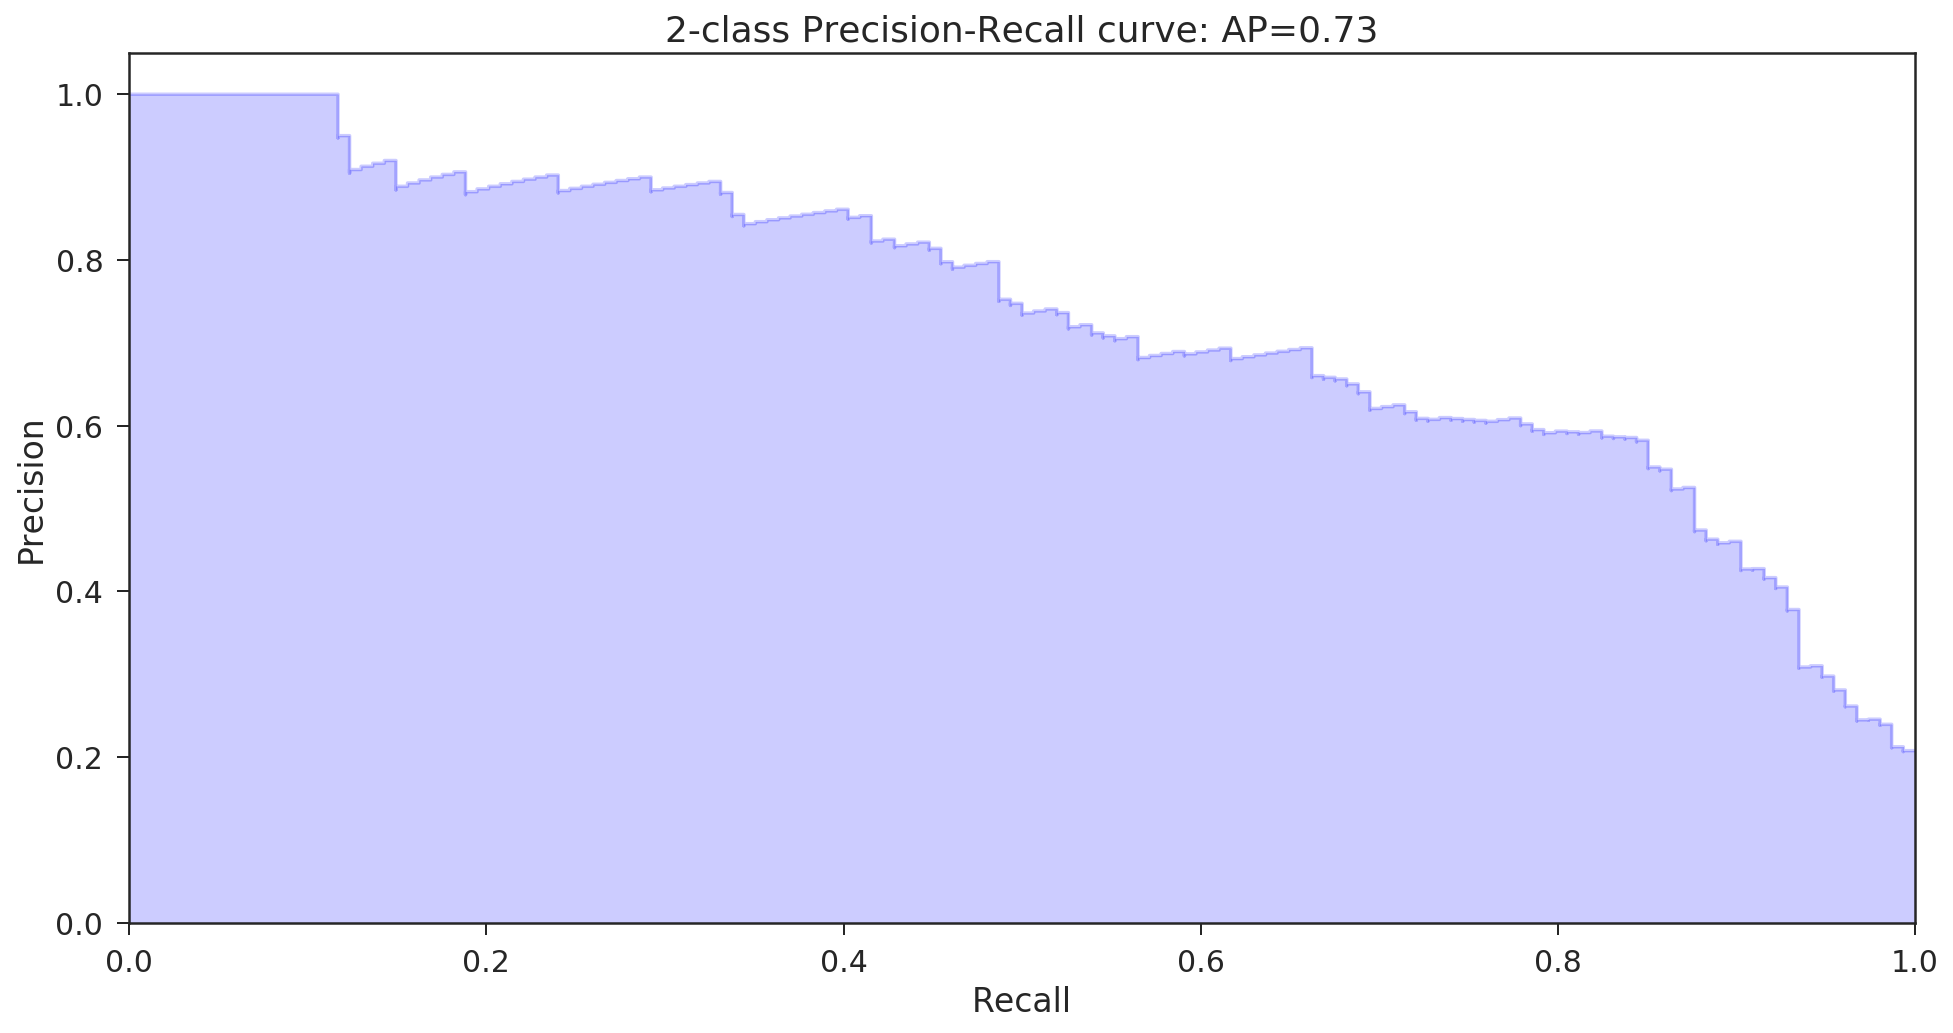

In [225]:
rbf_all_fpr, rbf_all_tpr, rbf_all_roc_auc, clf = svm_runner(X, Y, params, kernel=kernel, verbose=True)

##### RBF Kernel - Pref features

In [226]:
X = features[['danceability','speechiness']]
Y = targets['likeability']

In [227]:
params = {
    'C': [1.0,10.0,100.0],
    'gamma': [0.001, 0.01, 0.1, 1, 2, 5]
}

KERNEL: rbf
"Best params: {'C': 1.0, 'gamma': 1}"
'Best estimator score: 0.5834729455376798'
'Average Precision-recall score of Support Vector classifier on train set: 0.59'
'Average Precision-recall score of Support Vector classifier on test set: 0.59'
'Acuracy score of Support Vector Classifier on test set: 0.84'
'ROC AUC: 0.8559848132323702'


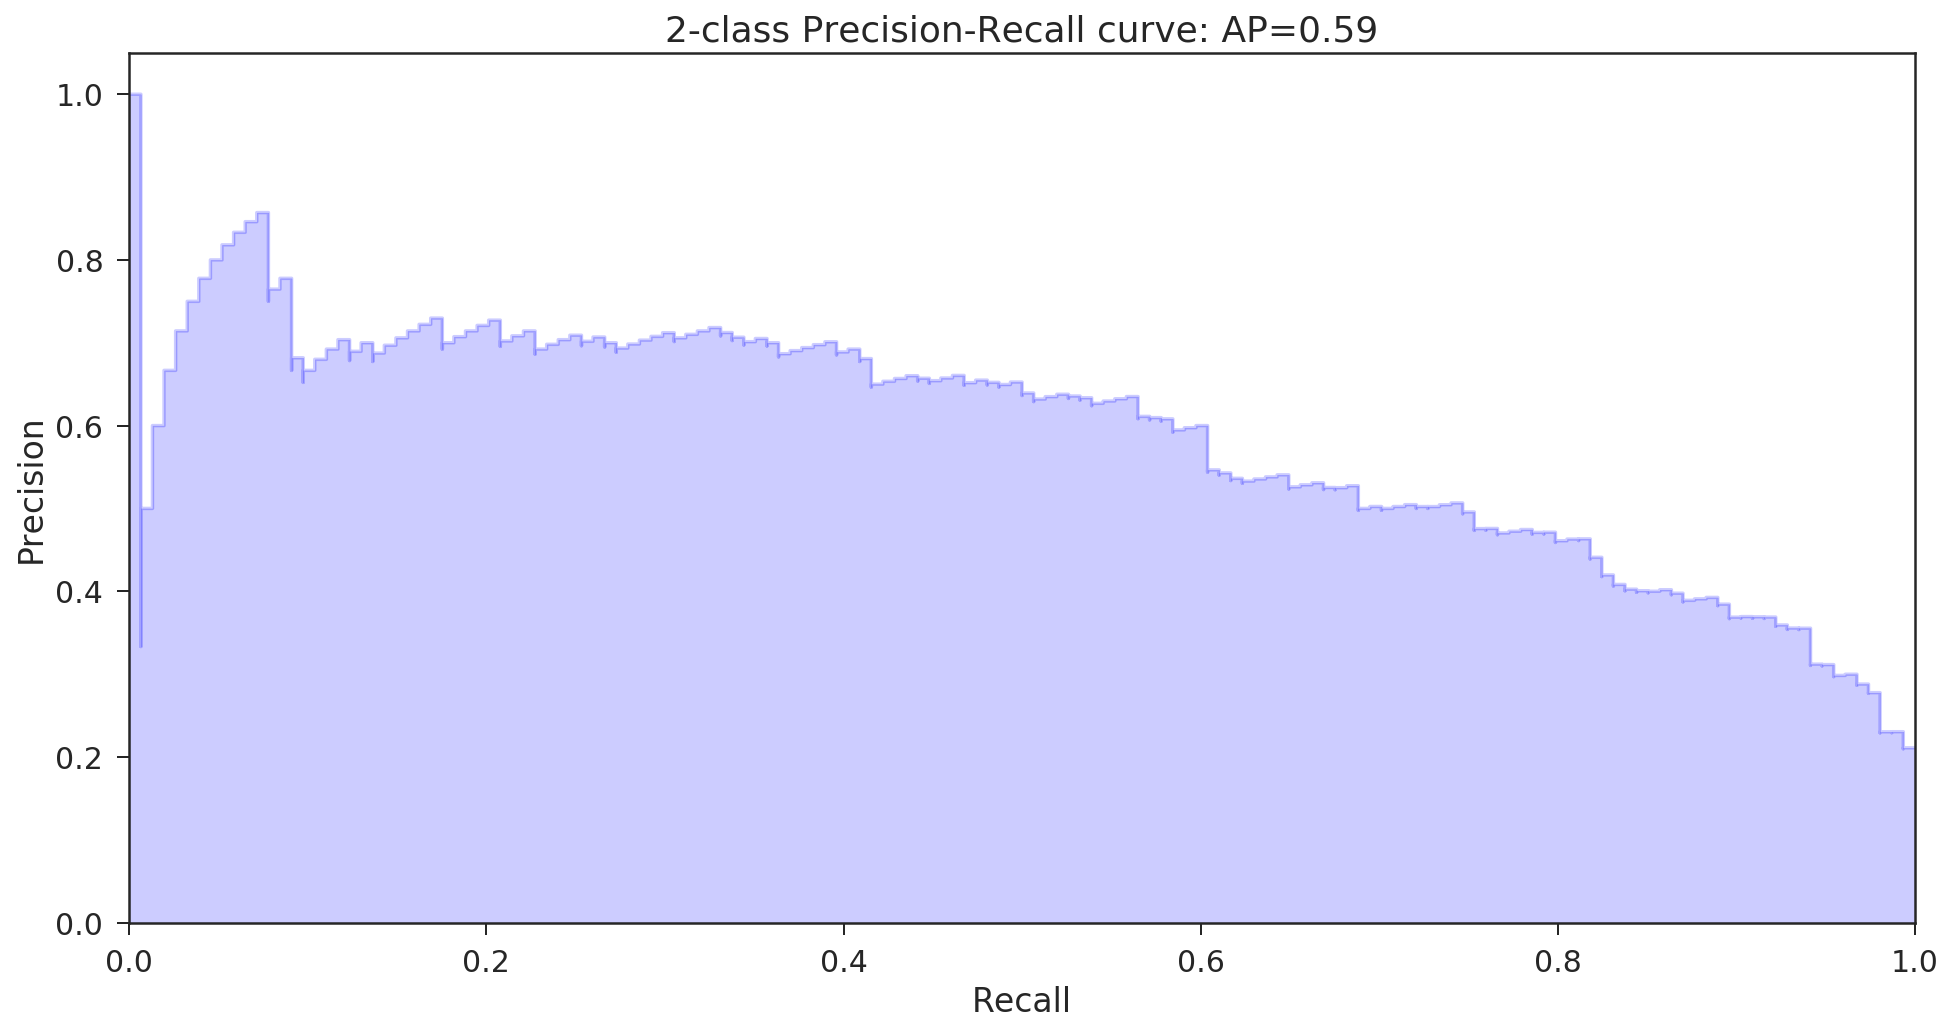

In [228]:
rbf_pref_fpr, rbf_pref_tpr, rbf_pref_roc_auc, clf = svm_runner(X, Y, params, kernel=kernel, verbose=True)

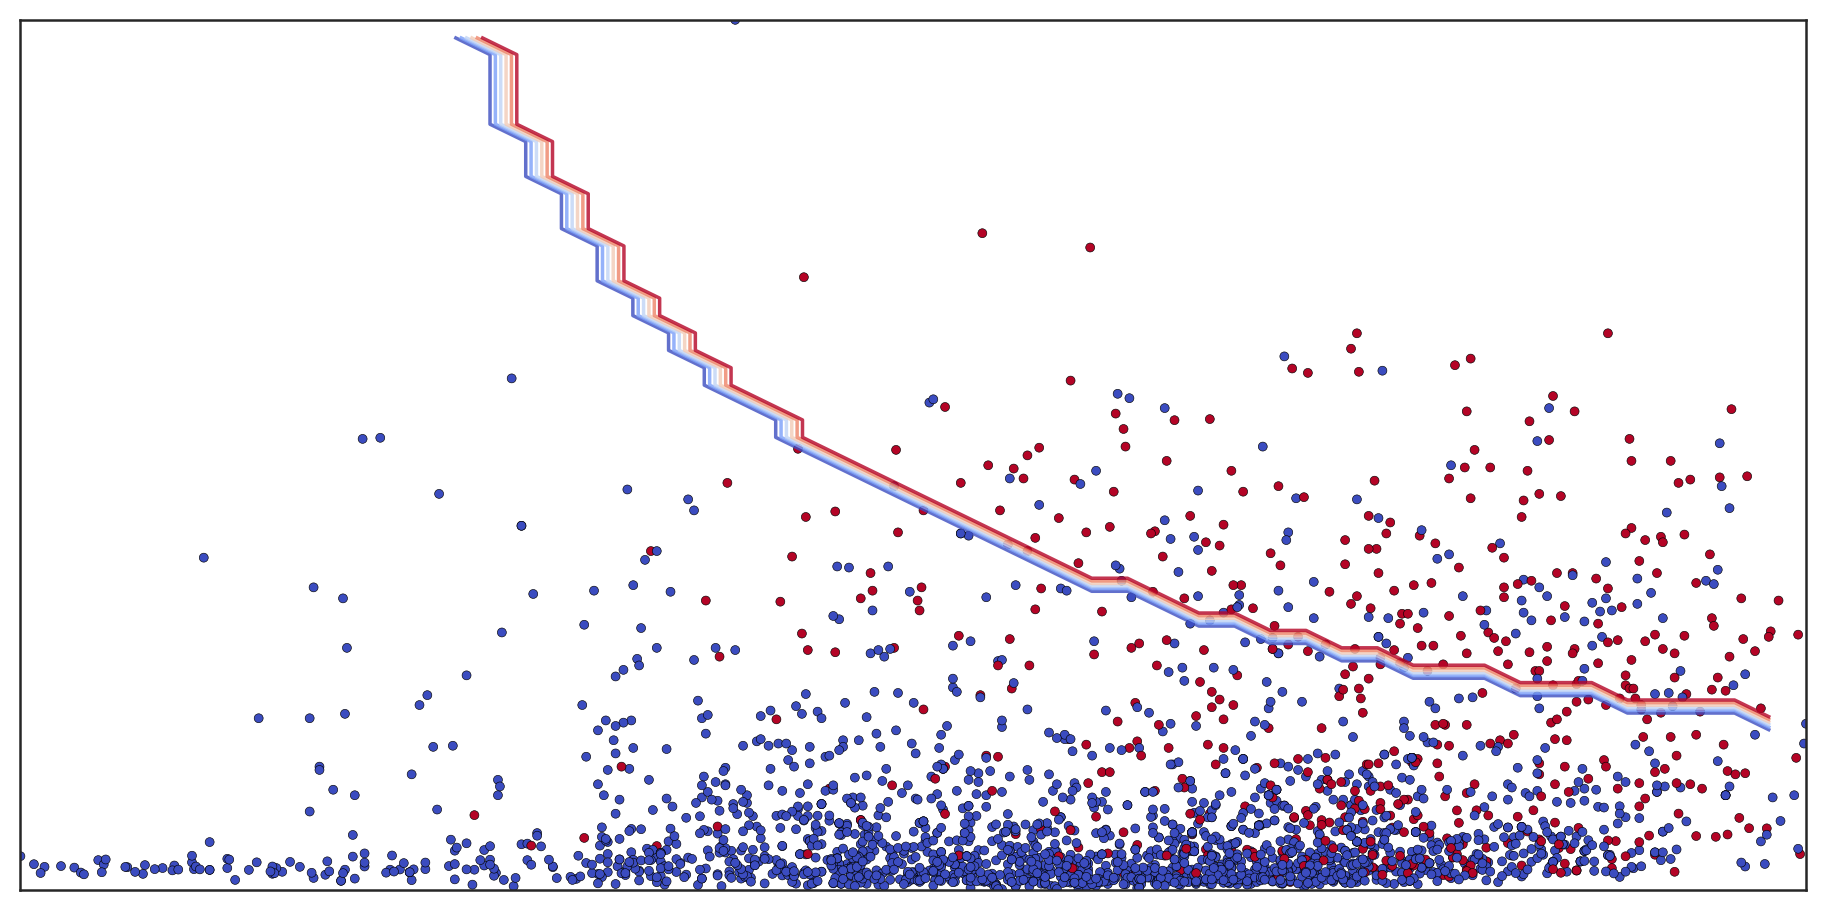

In [229]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(A.iloc[:,0], A.iloc[:,1], c=B, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks(())
ax.set_yticks(())
plt.show()

#### Neural Network

In [230]:
X, dummy_y = data[['danceability', 'speechiness', 'valence']], data.iloc[:, -1]

In [231]:
dummy_y.head(5)

36     0
115    1
313    0
90     0
0      0
Name: likeability, dtype: int64

In [232]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim=3, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    return model

In [233]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=512, verbose=0)

In [234]:
kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)

In [235]:
results = cross_val_score(estimator, X, dummy_y, cv=kfold)

In [236]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 80.80% (2.00%)


#### ROC Curve comparison

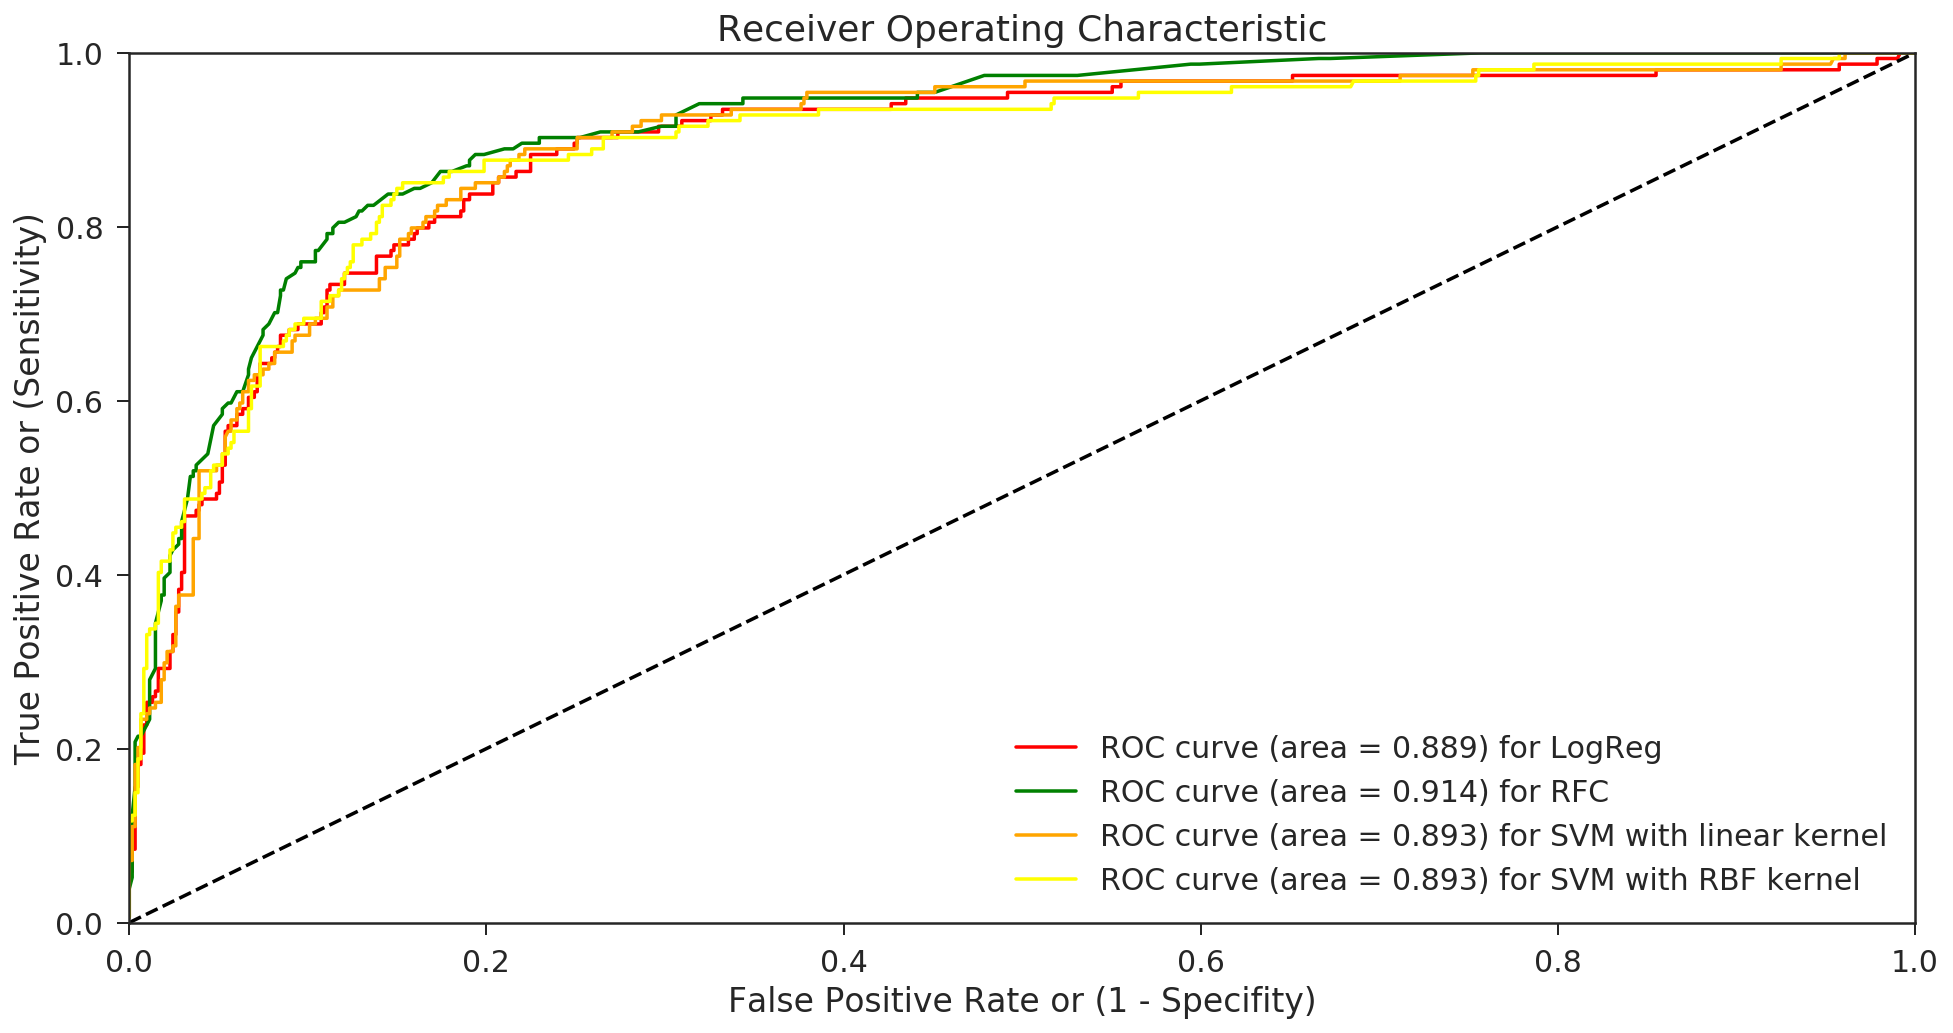

In [237]:
plt.plot(logreg_all_fpr, logreg_all_tpr,'r', label='ROC curve (area = %0.3f) for LogReg' % logreg_all_roc_auc)
plt.plot(rfc_all_fpr, rfc_all_tpr,'g',label = 'ROC curve (area = %0.3f) for RFC' % rfc_all_roc_auc)
plt.plot(linear_all_fpr, linear_all_tpr,'orange', label = 'ROC curve (area = %0.3f) for SVM with linear kernel' % linear_all_roc_auc)
plt.plot(rbf_all_fpr, rbf_all_tpr,'yellow', label = 'ROC curve (area = %0.3f) for SVM with RBF kernel' % rbf_all_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

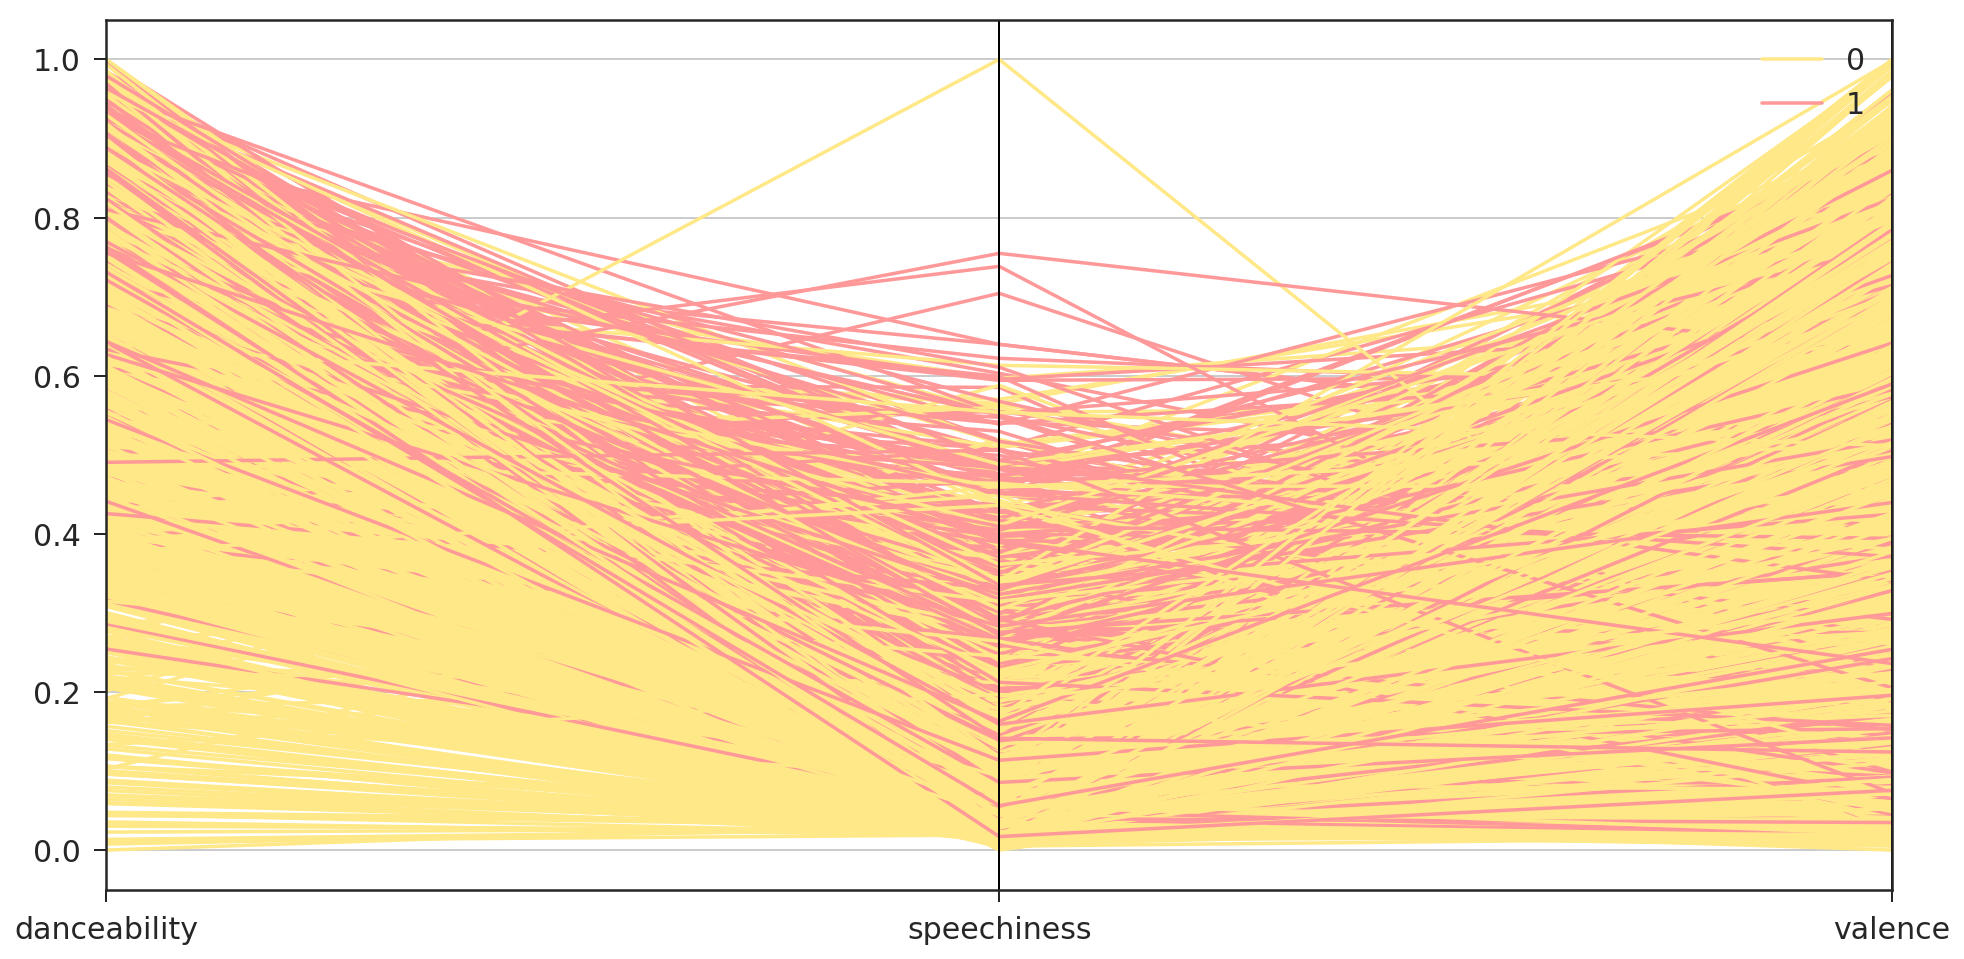

In [111]:
# clmns = list(data.columns.values)
# ranking = np.array(rfe.ranking_)
# inds  = np.where(ranking <=3)
# col = [clmns[x] for x in inds[0]]

X = features[preferred_features]
Y = targets['likeability']

data_norm = pd.concat([X, Y], axis=1)
parallel_coordinates(data_norm, 'likeability',color=['#FFE888', '#FF9999'])
plt.show()

### Unsupervised Learning

#### Principal Component Analysis

In [112]:
def pca_runner(x, n_components=3):
    min_max_scaler = MinMaxScaler()
    x = min_max_scaler.fit_transform(x)
    pca = PCA(n_components=n_components)
    pca.fit(x)
    pca_x = pca.transform(x)
    pprint(pca.explained_variance_ratio_)
    return pca_x

In [113]:
def pca_plot(x, y, text='', n_components=3):
    x = pca_runner(x, n_components)
    fig = {}
    if n_components == 2:
        fig = {
            "data": [
                {
                    "x": x[:, 0],
                    "y": x[:, 1],
                    "text": text,
                    "mode": "markers",
                    "marker": {"size": "8", "color": y}
                }
            ]
        }
    else:
        trace = go.Scatter3d(
                    x=x[:, 0],
                    y=x[:, 1],
                    z=x[:, 2],
                    text=text,
                    mode="markers",
                    marker={"size": "8", "color": y}
                )
        fig = go.Figure(data=[trace])
    return fig

In [114]:
preferred_features = ['valence', 'tempo', 'danceability', 'speechiness']

##### Visualize danceability

In [115]:
X = features[preferred_features].values
Y = features['danceability'].values
text = archived["name"] + " - " + archived["genre"]
text = text.values

In [116]:
fig = pca_plot(X, Y, text=text, n_components=3)
py.iplot(fig, filename="danceability-graph-3d")

array([ 0.47546871,  0.2441309 ,  0.17973427])


In [117]:
fig = pca_plot(X, Y, text=text, n_components=2)
py.iplot(fig, filename="danceability-graph-2d")

array([ 0.47546871,  0.2441309 ])


##### Visualize speechiness

In [118]:
X = features[preferred_features].values
Y = features['speechiness'].values
text = archived["name"] + " - " + archived["genre"]
text = text.values

In [119]:
fig = pca_plot(X, Y, text=text, n_components=3)
py.iplot(fig, filename="speechiness-graph-3d")

array([ 0.47546871,  0.2441309 ,  0.17973427])


In [120]:
fig = pca_plot(X, Y, text=text, n_components=2)
py.iplot(fig, filename="speechiness-graph-2d")

array([ 0.47546871,  0.2441309 ])


##### Visualize valence

In [121]:
X = features[preferred_features].values
Y = features['valence'].values
text = archived["name"] + " - " + archived["genre"]
text = text.values

In [122]:
fig = pca_plot(X, Y, text=text, n_components=3)
py.iplot(fig, filename="valence-graph-3d")

array([ 0.47546871,  0.2441309 ,  0.17973427])


In [123]:
fig = pca_plot(X, Y, text=text, n_components=2)
py.iplot(fig, filename="valence-graph-2d")

array([ 0.47546871,  0.2441309 ])


##### Clustering based on genre

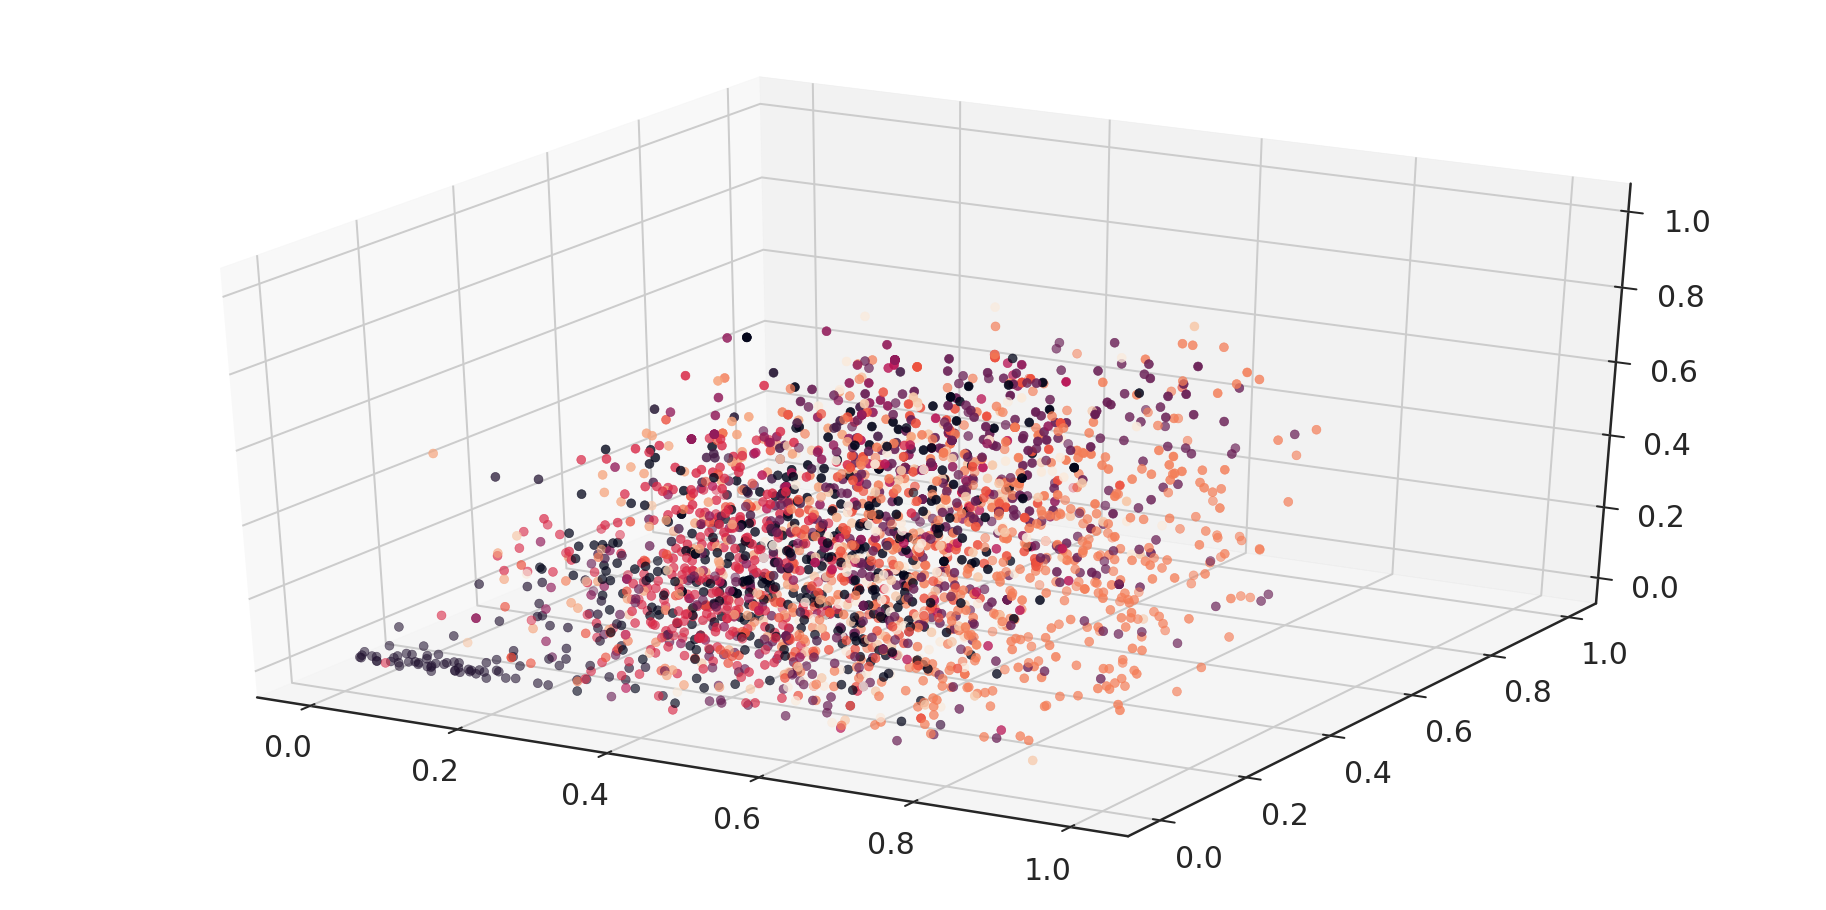

In [273]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Generate the values
x_vals = features[preferred_features].iloc[:, 0]
y_vals = features[preferred_features].iloc[:, 1]
z_vals = features[preferred_features].iloc[:, 2]

# Plot the values
ax.scatter(x_vals, y_vals, z_vals, c = data['genre'], marker='o')

plt.show()

##### K-Means

In [124]:

# clusters = kmeans.fit_predict(features)

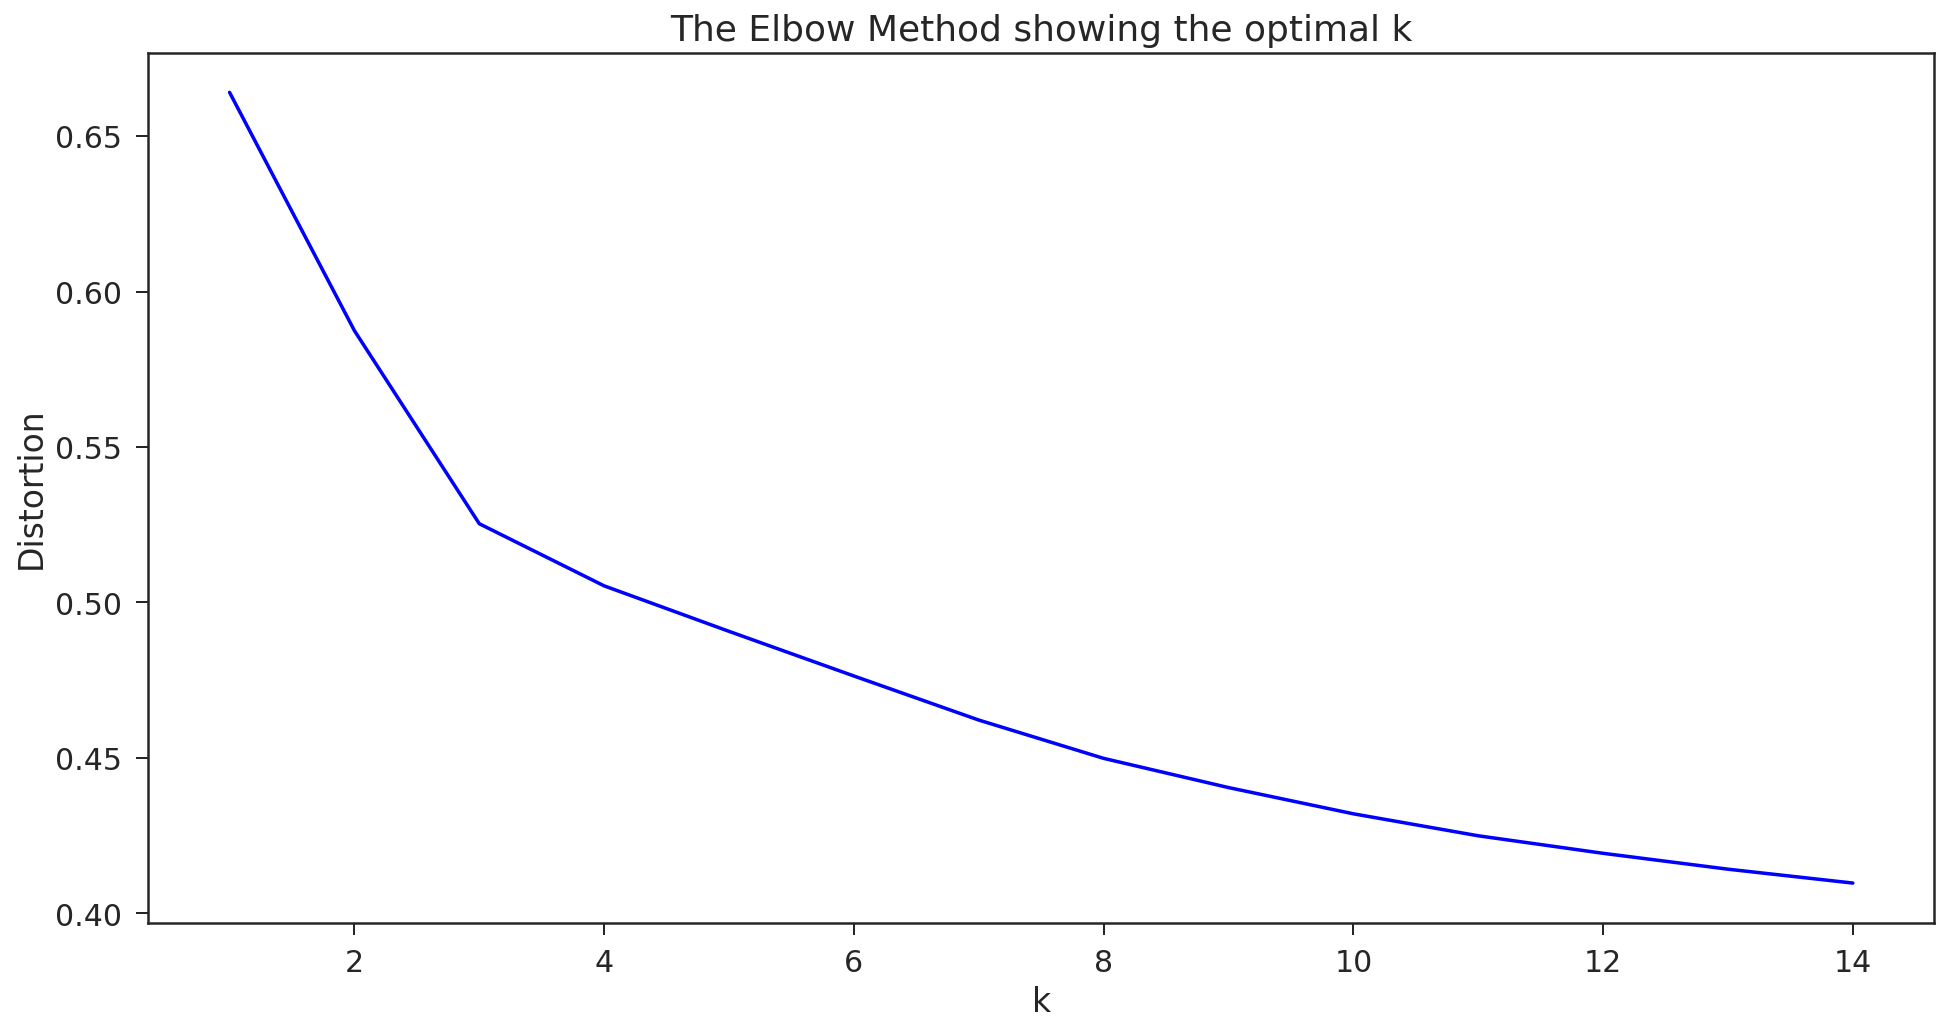

In [319]:
kmeans_features = features
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=random_state).fit(kmeans_features)
    kmeanModel.fit(kmeans_features)
    distortions.append(sum(np.min(cdist(kmeans_features, kmeanModel.cluster_centers_, 'minkowski'), axis=1)) / kmeans_features.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [320]:
np.random.seed(5)

fig = tls.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])
scene = dict(
    camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=2.5, y=0.1, z=0.1)
    )
)

est = KMeans(n_clusters=3, random_state=random_state).fit(kmeans_features)
est.fit(kmeans_features)

labels = est.labels_
trace = go.Scatter3d(x=kmeans_features.iloc[:, 0], y=kmeans_features.iloc[:, 1], z=kmeans_features.iloc[:, 2],
                     showlegend=False,
                     mode='markers',
                     marker=dict(
                            color=labels.astype(np.float),
                            line=dict(color='black', width=1)
    ))
fig.append_trace(trace, 1, 1)

fig['layout'].update(height=600, width=600,
                     margin=dict(l=10,r=10))

fig['layout']['scene1'].update(scene)

In [307]:
py.iplot(fig)

In [321]:
features.shape

(2558, 11)

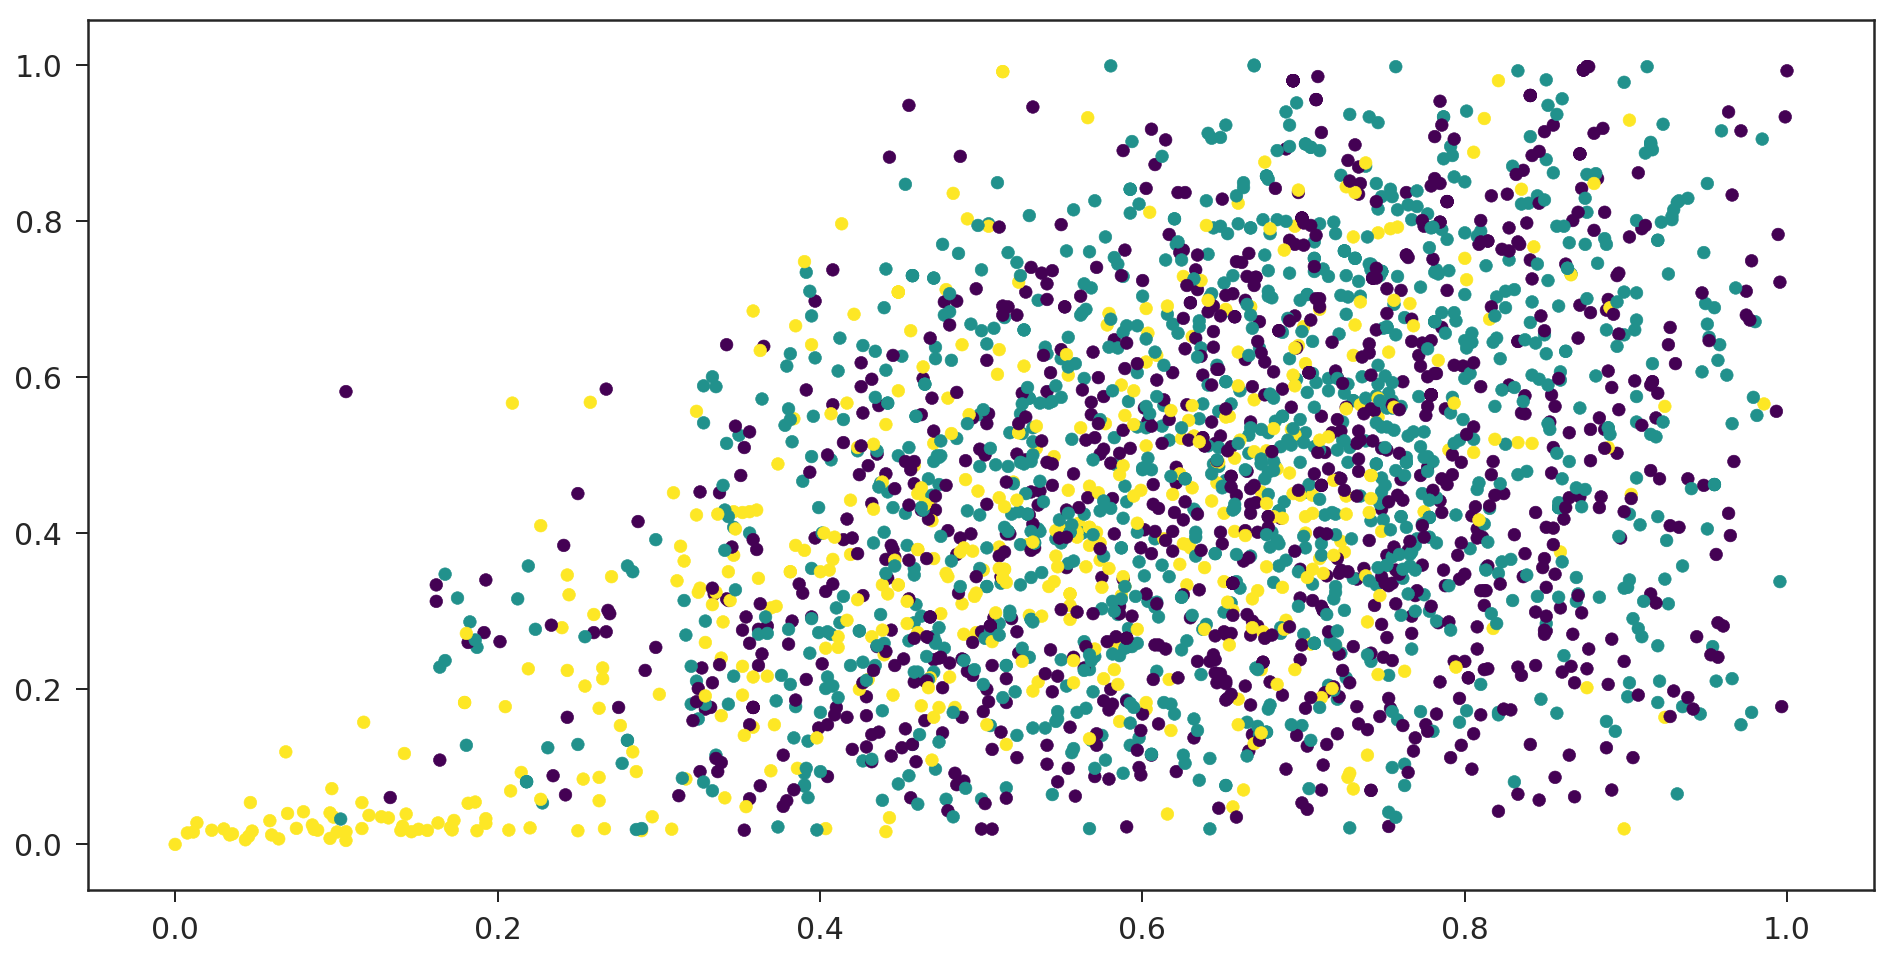

In [325]:
plt.scatter(features[preferred_features].iloc[:, 0], features[preferred_features].iloc[:, 2], c=labels, s=40, cmap='viridis')

##### Gaussian Mixture Models

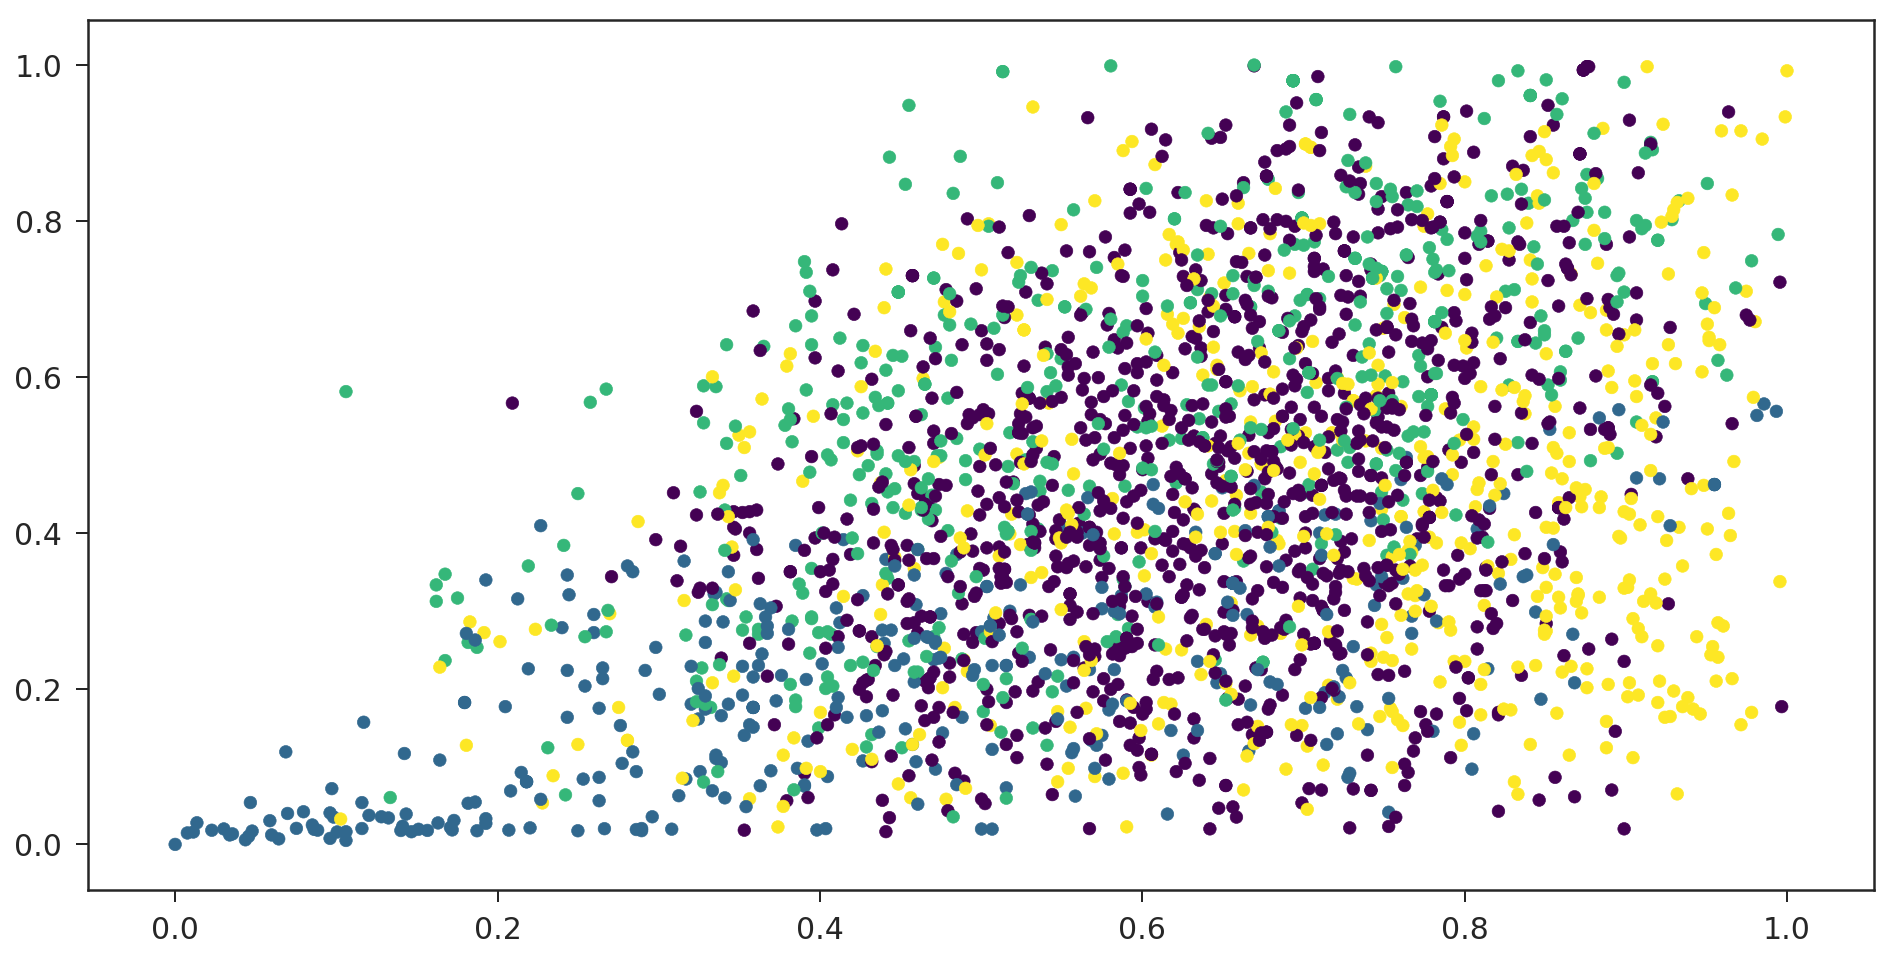

In [314]:
gmm = GaussianMixture(n_components=4).fit(features[preferred_features])
labels = gmm.predict(features[preferred_features])
plt.scatter(features[preferred_features].iloc[:, 0], features[preferred_features].iloc[:, 2], c=labels, s=40, cmap='viridis')

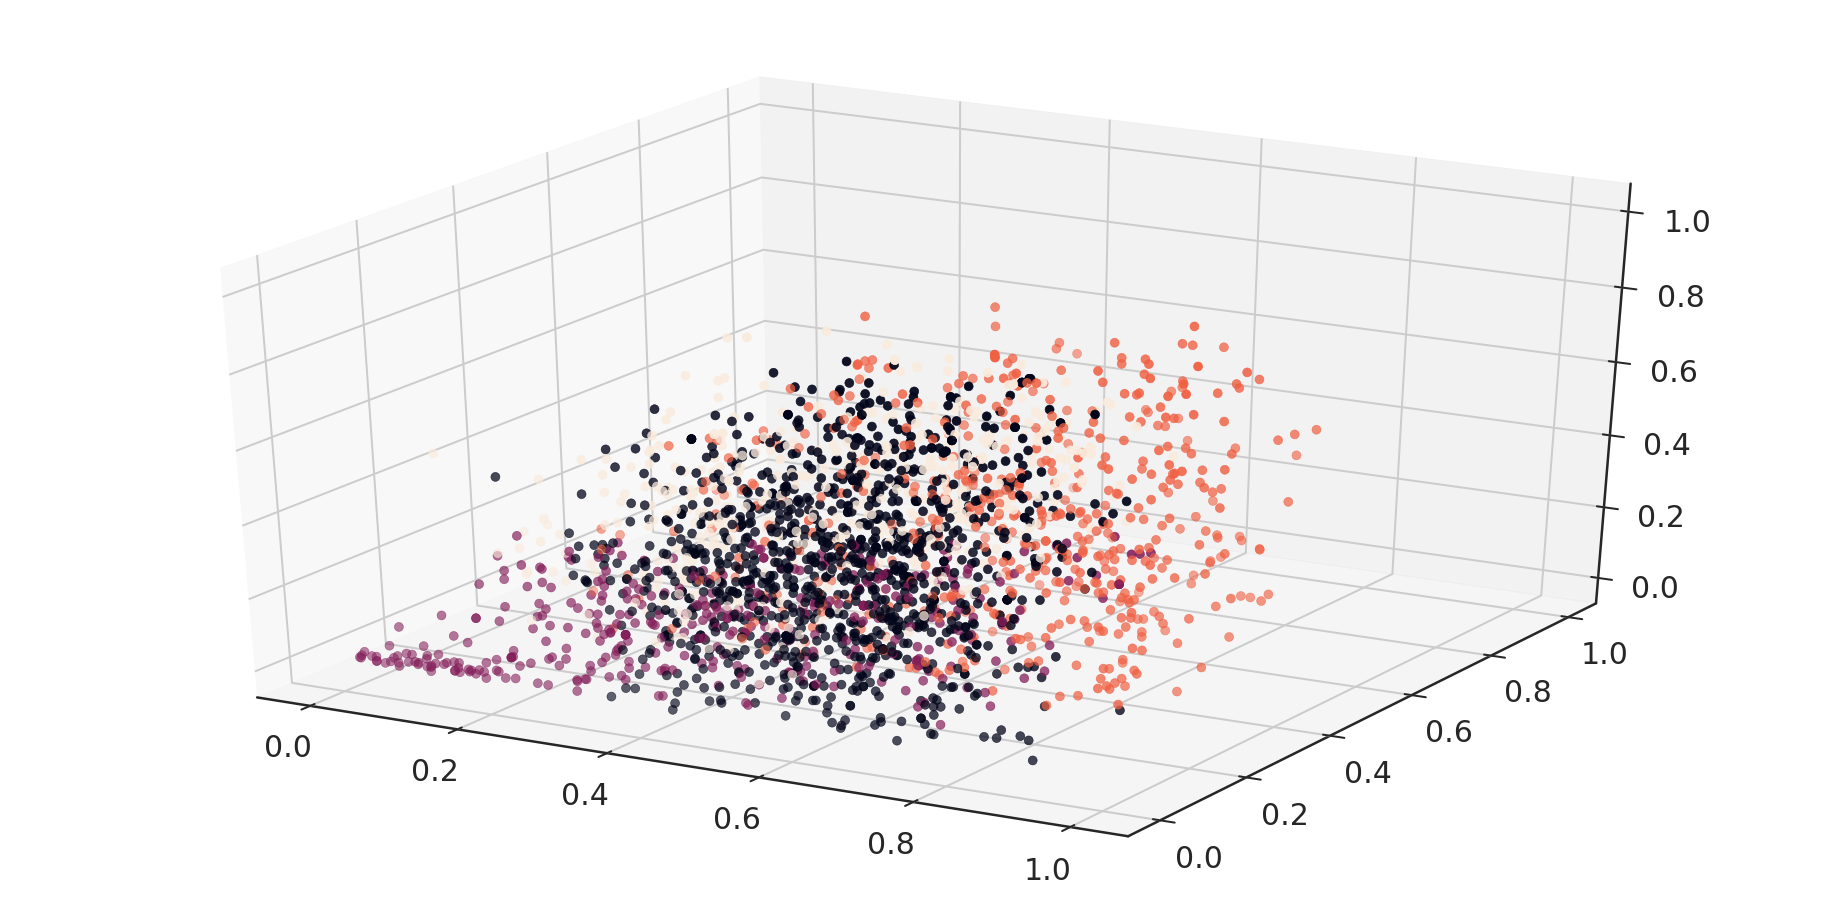

In [257]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Generate the values
x_vals = features[preferred_features].iloc[:, 0]
y_vals = features[preferred_features].iloc[:, 1]
z_vals = features[preferred_features].iloc[:, 2]

# Plot the values
ax.scatter(x_vals, y_vals, z_vals, c = labels, marker='o')

plt.show()

##### DBSCAN

In [349]:
dbscan = DBSCAN(eps=0.3, min_samples=10).fit(features)
dbscan_features = features.copy()
dbscan_features['Cluster'] = dbscan.labels_
dbscan_features['genre'] = targets.genre
dbscan_features.head(n=5)

popularity 
 acousticness 
 danceability 
 duration_ms 
 energy 
 key 
 liveness 
 loudness 
 speechiness 
 tempo 
 valence 
 Cluster 
 genre 
 
 
 
 
 36 
 0.252525 
 0.006360 
 0.762768 
 0.081014 
 0.839522 
 0.545455 
 0.044295 
 0.953606 
 0.052479 
 0.470369 
 0.102902 
 0 
 11 
 
 
 115 
 0.676768 
 0.501002 
 0.616694 
 0.085226 
 0.246757 
 1.000000 
 0.094476 
 0.759635 
 0.020359 
 0.367414 
 0.211609 
 -1 
 8 
 
 
 313 
 0.404040 
 0.037847 
 0.778144 
 0.088493 
 0.501516 
 0.818182 
 0.106866 
 0.894796 
 0.176783 
 0.612663 
 0.394195 
 0 
 3 
 
 
 90 
 0.808081 
 0.283129 
 0.649643 
 0.102931 
 0.568716 
 0.454545 
 0.066804 
 0.874568 
 0.005438 
 0.245429 
 0.827968 
 0 
 9 
 
 
 0 
 0.919192 
 0.041863 
 0.814388 
 0.072662 
 0.796394 
 0.090909 
 0.051833 
 0.909129 
 0.034396 
 0.155536 
 0.774142 
 0 
 5

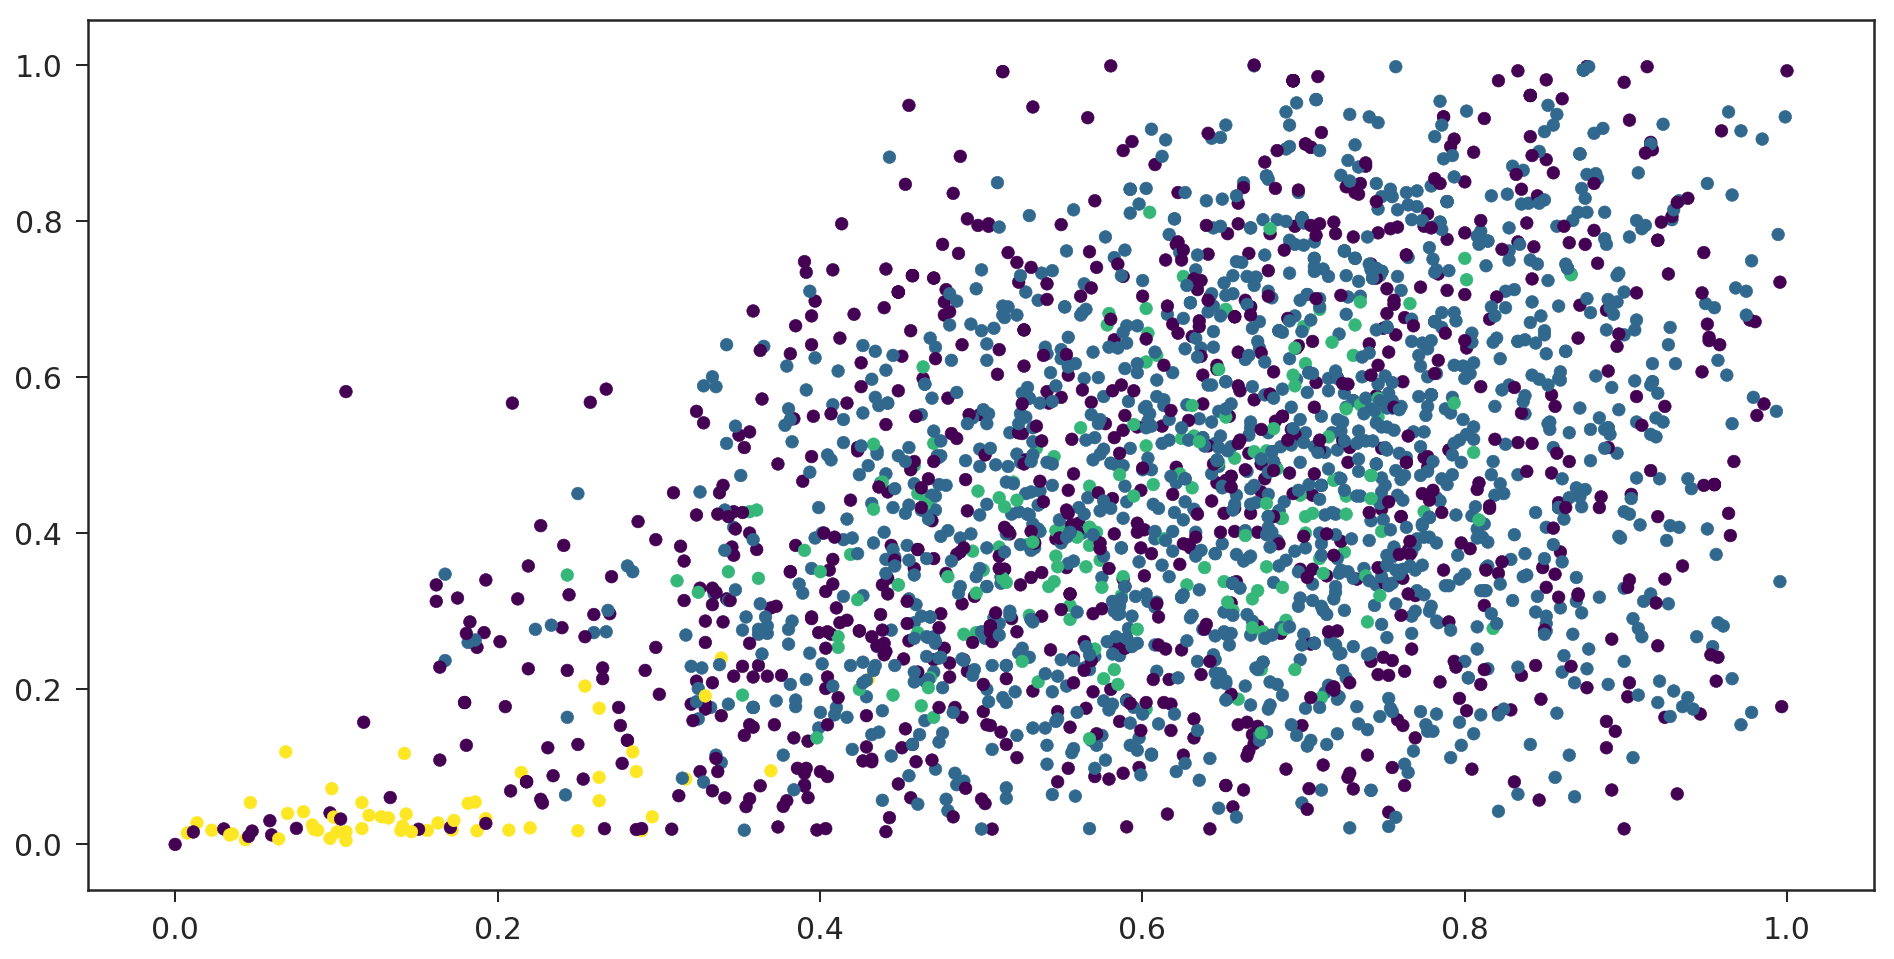

In [351]:
plt.scatter(features[preferred_features].iloc[:, 0], features[preferred_features].iloc[:, 2], c=dbscan.labels_, s=40, cmap='viridis')

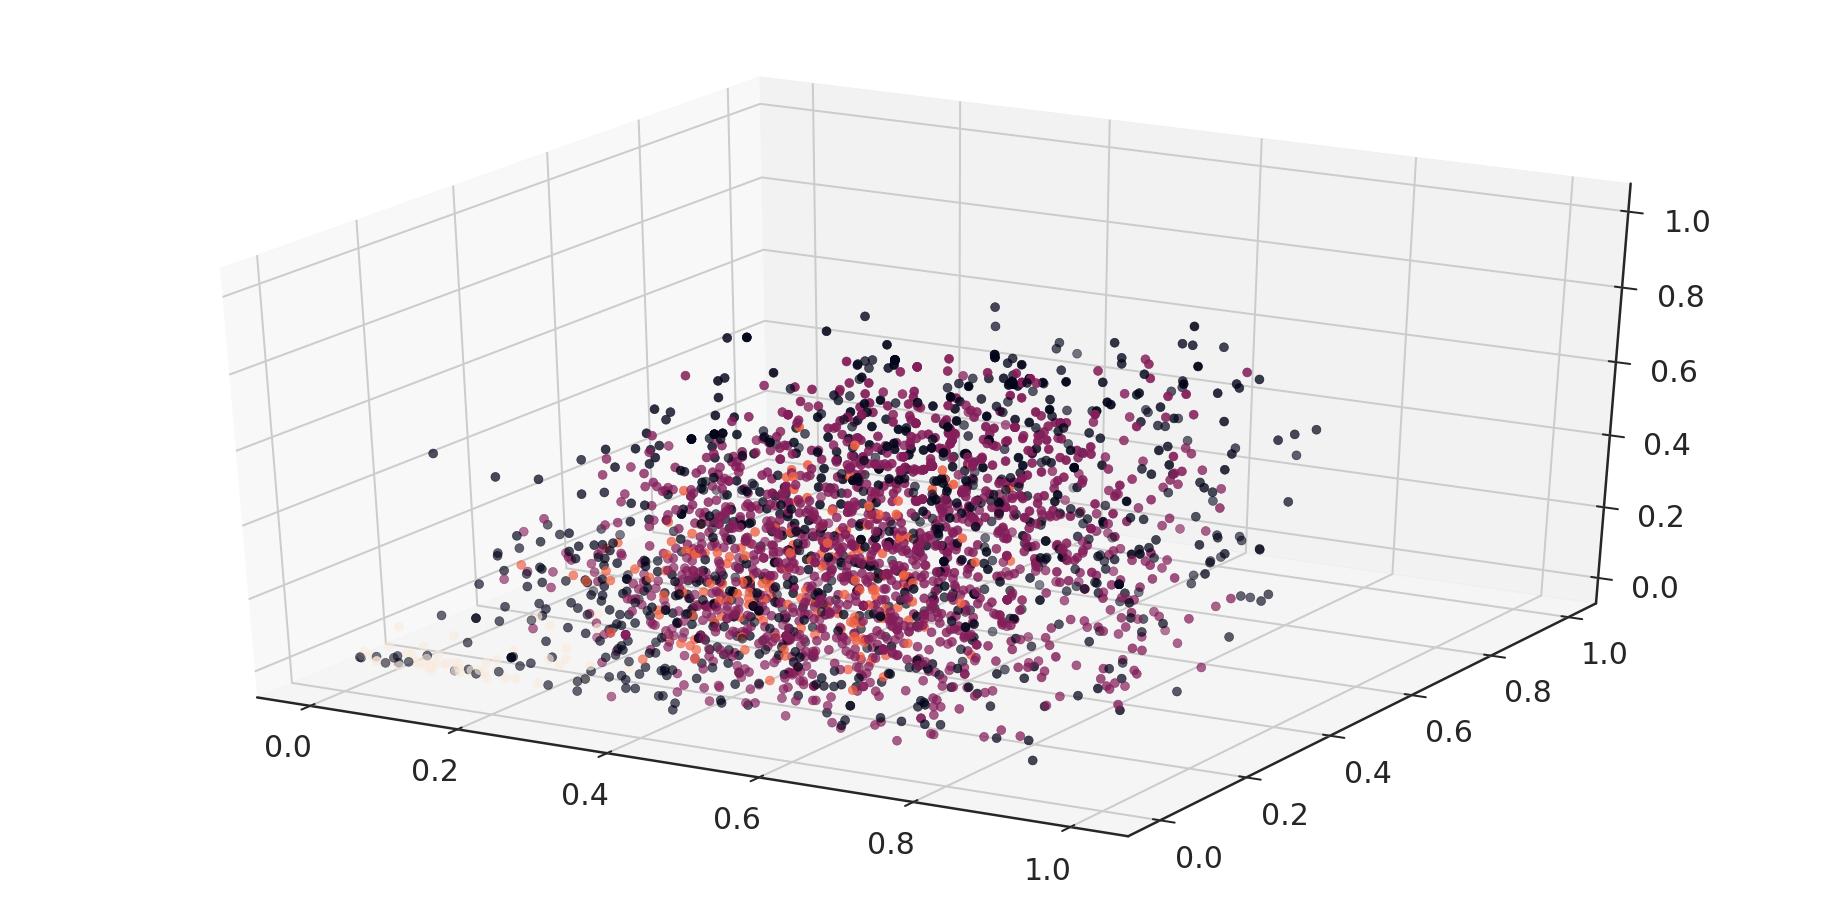

In [350]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Generate the values
x_vals = features[preferred_features].iloc[:, 0]
y_vals = features[preferred_features].iloc[:, 1]
z_vals = features[preferred_features].iloc[:, 2]

# Plot the values
ax.scatter(x_vals, y_vals, z_vals, c = dbscan.labels_, marker='o')

plt.show()

##### Agglomerative clustering

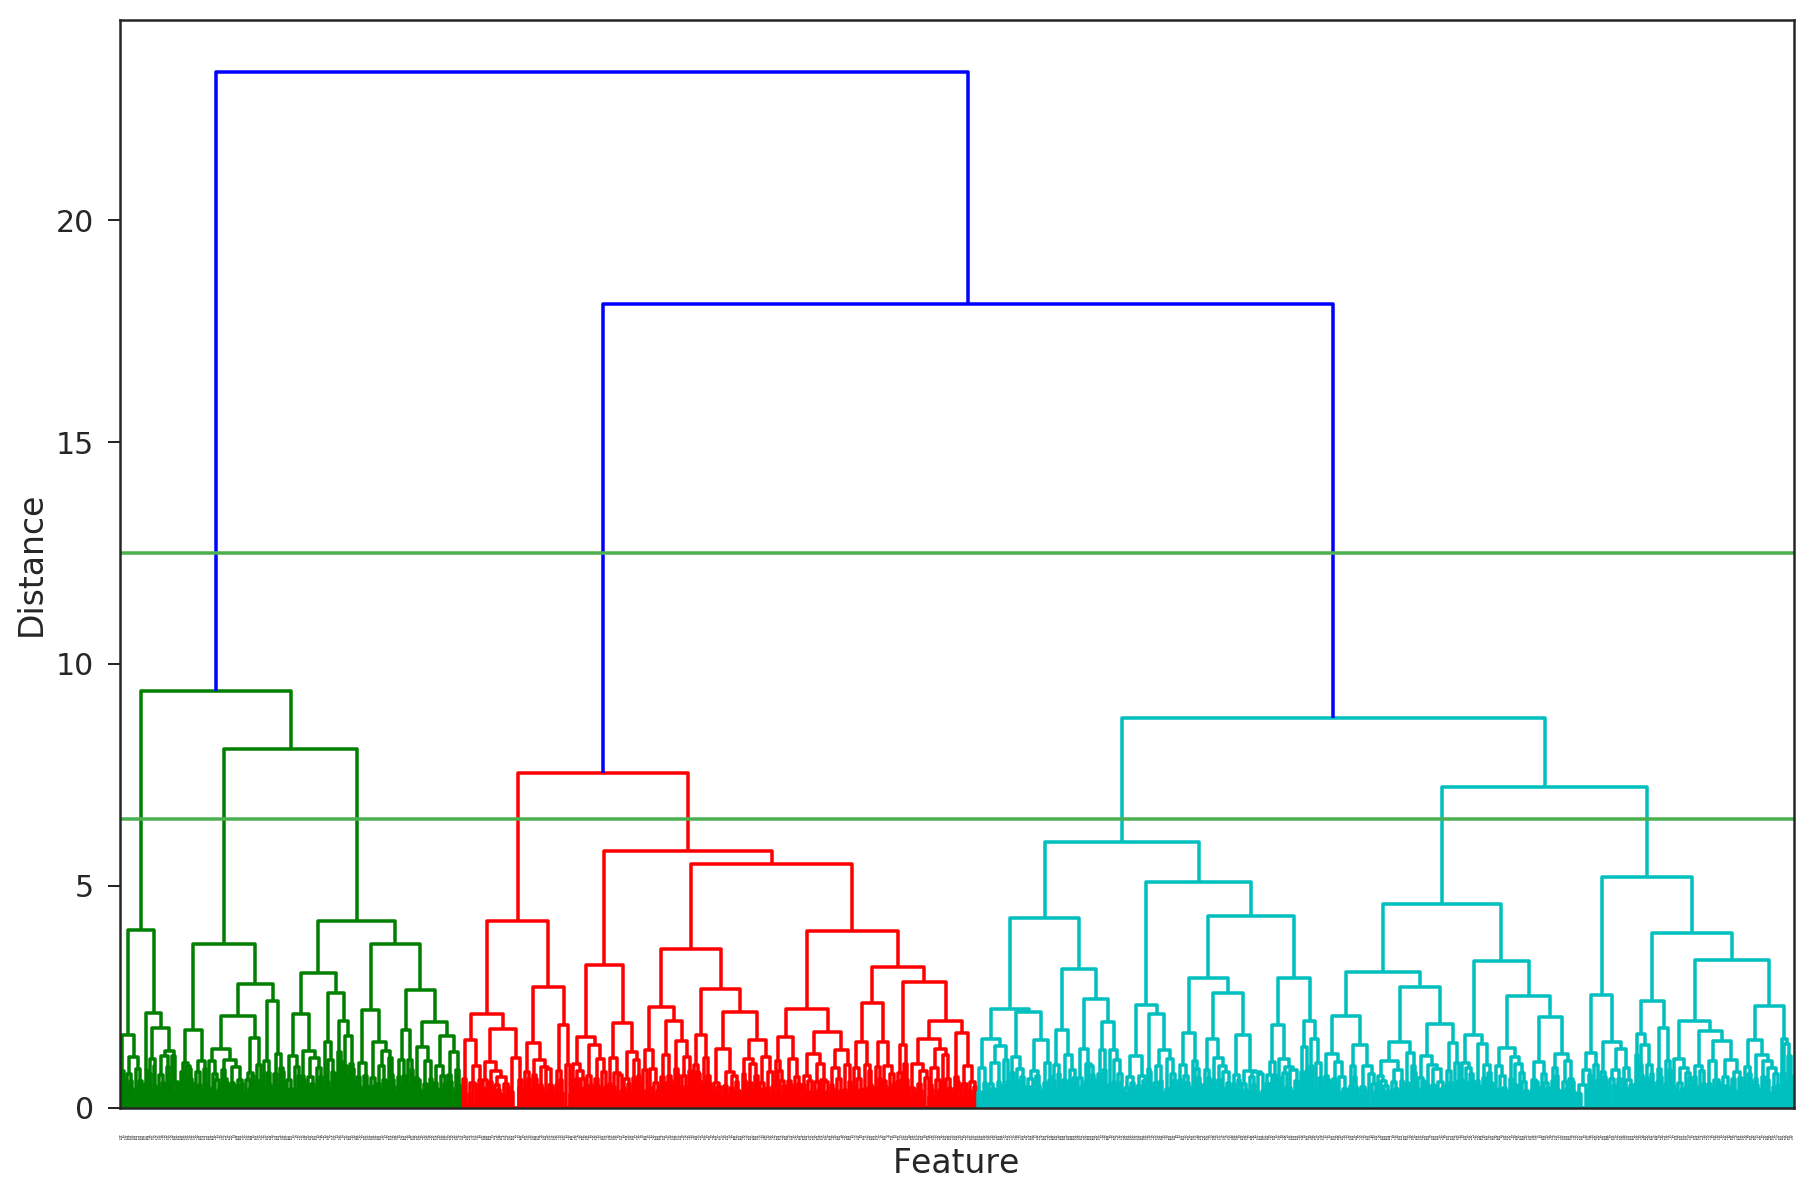

In [357]:
agglo = linkage(features, 'ward')
plt.figure(figsize=(15,10))
dendrogram(agglo, leaf_rotation=90., leaf_font_size=0., show_contracted=True)
plt.xlabel('Feature')
plt.ylabel('Distance')
plt.axhline(y = 12.5)
plt.axhline(y = 6.5)
plt.show()

In [358]:
data_matrix = np.array(features)
distance_matrix = pdist(data_matrix, 'minkowski')
print("cophentic correlation distance = %s" % (cophenet(agglo, distance_matrix)[0],))

cophentic correlation distance = 0.602805503308


### Sampling

In [359]:
def inverse_transform_sampling(data, n_bins=40, n_samples=1000):
    hist, bin_edges = np.histogram(data, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    return inv_cdf(r)